# echo assignment
Pipeline di Machine Learning con task di classificazione binaria per predizione di masse tumorali al seno (benigno vs maligno) basandosi su feature geometriche estratte da immagini digitali di un agoaspirato (FNA) di una massa mammaria.

Sono stati adottati diversi approcci per confrontare le performance dei modelli nei seguenti scenari:
* **Default**: modelli con parametri di default.
* **Tuned**: modelli con ottimizzazione degli iperparametri tramite **GridSearchCV**.
* **Ensemble**: combinazione di modelli tramite soft voting.
* **Dimensionality Reduction**: riduzione della dimensionalità mediante **PCA**.

## Modelli considerati
Sono stati considerati i seguenti algoritmi supervisionati di classificazione:
- *Support Vector Classifier*.
- *Decision Tree Classifier*.
- *Random Forest*.
- *GradientBoostingClassifier*.

## Metrica discriminante in ambito medico
In questo dominio (Digital Health), si è ritenuto considerare la **Recall** come metrica di validazione come discriminante per la selezione dei modelli "migliori". Massimizzare la recall significa **minimizzare i False Negative** (predire "benigno" un tumore "maligno" rappresenta **l'errore più grave**).

## Struttura universale delle pipeline
Il flusso di lavoro per ciascuna pipeline è modulare e segue questi sempre questi step:
1.  **Data exploration**:
    * Analisi valori mancanti.
    * Analisi varianza delle feature.
    * Analisi delle correlazioni.
2.  **Preprocessing & feature engineering:**
    * Rimozione feature non informative (ID, colonne vuote).
    * Standardizzazione feature.
3.  **Tuning & validation**
    * Per ciasun algoritmo, si confrontano le performance del modello **Default** contro una versione **Tuned** (per entrambi gli approcci è stata applicata la k-fold cross validation).
4.  **Ensemble**
    * Implementazione di una tecnica di ensemble con logica di soft voting per aggregazione predizioni modelli.

## Definizione pipeline
Costruzione delle singole pipeline confrontare l'impatta di singoli aggiunte sui risultati.
* **Basic:** scaling + classificazione.
* **Select + SMOTE:** scaling + feature selection (varianza/corr) + oversampling (SMOTE) + classificazione.
* **SMOTE + PCA:** scaling + oversampling + riduzione dimensionalità (PCA) + classificazione.

In [1]:
import json
from pathlib import Path
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn import clone
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree


## Costanti
Configurazioni costanti

In [2]:
# path al dataset
DATASET_PATH = "data.csv"

# cartella per salvataggio configurazione iperparametri
# ottimizzati tramite GridSearchCV
HYPERPARAMETERS_DIR = Path("hyperparameters")
Path.mkdir(HYPERPARAMETERS_DIR, exist_ok=True)

# percorso iperparametri tuned (pipeline basic)
BASIC_HYPERPARAMETERS_PATH = Path(f"{HYPERPARAMETERS_DIR}/basic_hyperparameters.json")

# percorso iperparametri (pipeline con feature selection + smote)
SMOTE_HYPERPARAMETERS_PATH = Path(f"{HYPERPARAMETERS_DIR}/smote_hyperparameters.json")

# percorso iperparametri (pipeline con smote + pca)
PCA_HYPERPARAMETERS_PATH = Path(f"{HYPERPARAMETERS_DIR}/pca_hyperparameters.json")

# seed fisso per riproducibilità dei risultati
RANDOM_STATE = 42

# soglia di varianza cumulativa per la pca
CUMULATIVE_PCA_VARIANCE_THRESHOLD = 0.90

# nome della colonna target
TARGET = 'diagnosis'

# numero folds per cross validation
N_FOLDS = 5

# metrcia discriminante per la grid search cv
GRID_SEARCH_CV_SCORING_DISCRIMINANT = "recall_macro"

# flag per abilitare o disabilitare il fine-tuning dei modelli
FINETUNING_FLAG = False

# rapporto di oversampling: bilancia la classe minoritaria fino all’80% della maggioritaria
OVERSAMPLING_RATIO = 0.80

# soglia minima di varianza per eliminare feature poco informative
LOW_VARIANCE_THRESHOLD = 0.01

# soglia minima di correlazione per il filtraggio delle feature
LOW_CORRELATION_THRESHOLD = 0.5

## Configurazione modelli e iperparametri
Definizione "dizionario dei modelli" e relative griglie di iperparametri. Si istanziamo in `model_dict` i classificatori che verranno testati e, per ciasuno di essi, si definisce una griglia di parametri in `param_grids` per la grid search.

In [3]:
models_dict = {
    "SVC" : SVC(probability=True, random_state=RANDOM_STATE),
    "DecisionTreeClassifier" : DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForestClassifier" : RandomForestClassifier(random_state=RANDOM_STATE),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=RANDOM_STATE)
}

In [4]:
# griglie di ricerca per GridSearchCV.
# Ogni chiave corrisponde al nome del modello in 'models_dict'.
param_grids = {
    'SVC': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'degree': [2, 3]
    },

    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    },

    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False],
        'criterion': ['gini', 'entropy']
    },

    'GradientBoostingClassifier': {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'max_features': ['sqrt', 'log2', None]
    }
}

In [5]:
# classe per implementazione della rimozione delle feature che hanno 
# varianza troppo bassa (<= LOW_VARIANCE_THRESHOLD) e correlazione 
# troppo debole con il target (<= LOW_CORRELATION_THRESHOLD).
class CorrelationVarianceSelector(BaseEstimator, TransformerMixin):
    def __init__(self, var_threshold=LOW_VARIANCE_THRESHOLD, corr_threshold=LOW_CORRELATION_THRESHOLD):
        self.var_threshold = var_threshold
        self.corr_threshold = corr_threshold
        self.features_to_keep = None

    def fit(self, X, y=None):
        # calcolo varianza
        variances = X.var()
        low_var_cols = variances[variances < self.var_threshold].index

        # calcolo correlazione con target
        correlations = X.corrwith(y).abs()
        low_corr_cols = correlations[correlations <= self.corr_threshold].index

        # colonne da rimuovere
        to_remove = [c for c in X.columns if c in low_var_cols and c in low_corr_cols]

        # colonne da tenere
        self.features_to_keep = [c for c in X.columns if c not in to_remove]
        return self

    def transform(self, X):
        return X[self.features_to_keep]

## Definizione pipeline

In [6]:
pipe_basic = Pipeline([
    ('scaler', StandardScaler().set_output(transform="pandas")),

    ('classifier', None), #default
])

pipe_selector_smote = Pipeline([
    ('scaler', StandardScaler().set_output(transform="pandas")),

    ('selector', CorrelationVarianceSelector(var_threshold=LOW_VARIANCE_THRESHOLD, 
                                             corr_threshold=LOW_CORRELATION_THRESHOLD)),

    ('smote', SMOTE(sampling_strategy=OVERSAMPLING_RATIO, random_state=RANDOM_STATE)),

    ('classifier', None), #default
])

pipe_smote_pca = Pipeline([
    ('scaler', StandardScaler().set_output(transform="pandas")),

    ('smote', SMOTE(sampling_strategy=OVERSAMPLING_RATIO, random_state=RANDOM_STATE)),

    ('pca', PCA(random_state=RANDOM_STATE)),

    ('classifier', None), #default
])

In [7]:
# dizionario per accesso alle pipeline
pipelines_dict : dict[str, Pipeline] = {
    "basic": pipe_basic,
    "select_smote" : pipe_selector_smote,
    "smote_pca": pipe_smote_pca,
}

## Ispezione preliminare
Caricamento del dataset e verifica:
* dimensionalità.
* colonne.
* valori nulli (per eventuale imputazione).
* tipo di dati (tutti numerici tranne il target).
* statistiche descrittive per ciascuna feature

In [8]:
# caricamento dataset
original_df = pd.read_csv(DATASET_PATH)

In [9]:
# dimensionalità
original_df.shape

(569, 33)

In [10]:
# colonne, valori nulli e tipi di dati
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [11]:
# statistiche descrittive feature
original_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.106000,0.161900,0.179200,1.957000e-01,3.040000e-01


Eliminazione features: id e Unnamed

In [12]:
df = original_df.copy()

# rimozione caratteristiche: "id" (non informativa), "Unnamed: 32" (tutti valori nulli)
df = df.drop(columns=["id", "Unnamed: 32"])

## Analisi distribuzione classi
Visualizzazione proporzione classi: diagnosi benigne (B) e maligne (M).

In [13]:
# visualizzazione classi con conteggio
target_counts = df[TARGET].value_counts()
target_counts

diagnosis
B    357
M    212
Name: count, dtype: int64

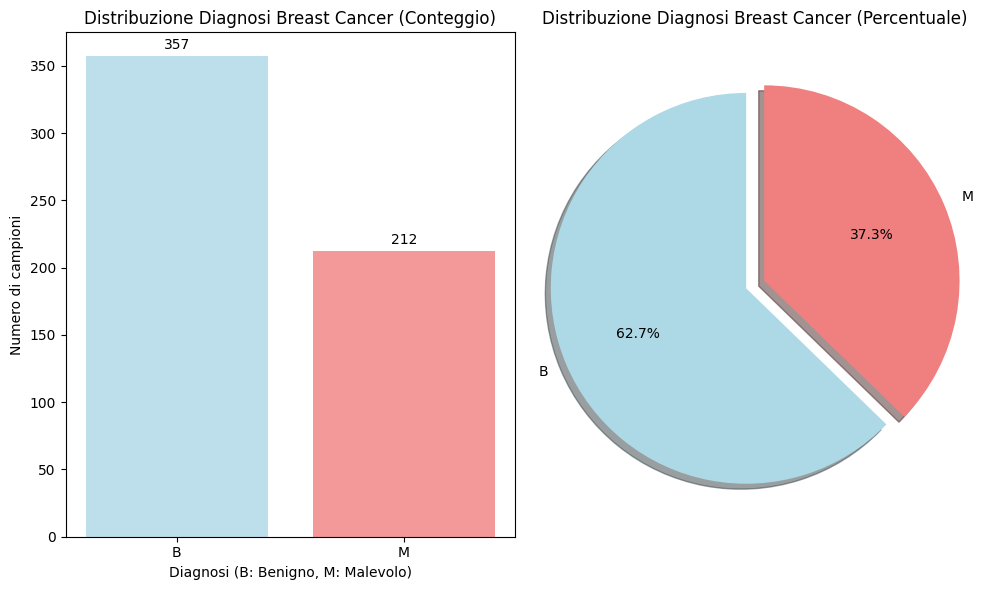

In [14]:
# bar plot e pie chart distribuzione classi
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
bars = plt.bar(target_counts.index, target_counts.values,
               color=['lightblue', 'lightcoral'], alpha=0.8)
plt.title('Distribuzione Diagnosi Breast Cancer (Conteggio)')
plt.xlabel('Diagnosi (B: Benigno, M: Malevolo)')
plt.ylabel('Numero di campioni')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 3,
             f'{height}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
colors = ['lightblue', 'lightcoral']
explode = (0.05, 0.05)
plt.pie(target_counts.values, labels=target_counts.index, colors=colors,
        autopct='%1.1f%%', startangle=90, explode=explode, shadow=True)
plt.title('Distribuzione Diagnosi Breast Cancer (Percentuale)')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [15]:
# Encoding target: 0 (B), 1 (M)
le = LabelEncoder()
df[TARGET] = le.fit_transform(df[TARGET])

## Correlazioni e varianza
Analisi varianza delle feature e delle loro correlazioni.

In [16]:
# funzione per generare una heatmap triangolare.
def plot_correlation_matrix(df: pd.DataFrame, target_name: str = TARGET):
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    plt.figure(figsize=(16, 12))

    sns.set_theme(style="white")

    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap='coolwarm',
        annot=True,
        fmt=".1f",
        annot_kws={
            "size": 8,
            "weight": "bold"
        },
        linewidths=0.5,
        linecolor='white',
        square=True,
        cbar_kws={"shrink": .8},
        center=0
    )

    plt.title(f'Matrice di Correlazione - Target: {target_name}', fontsize=16)
    plt.show()

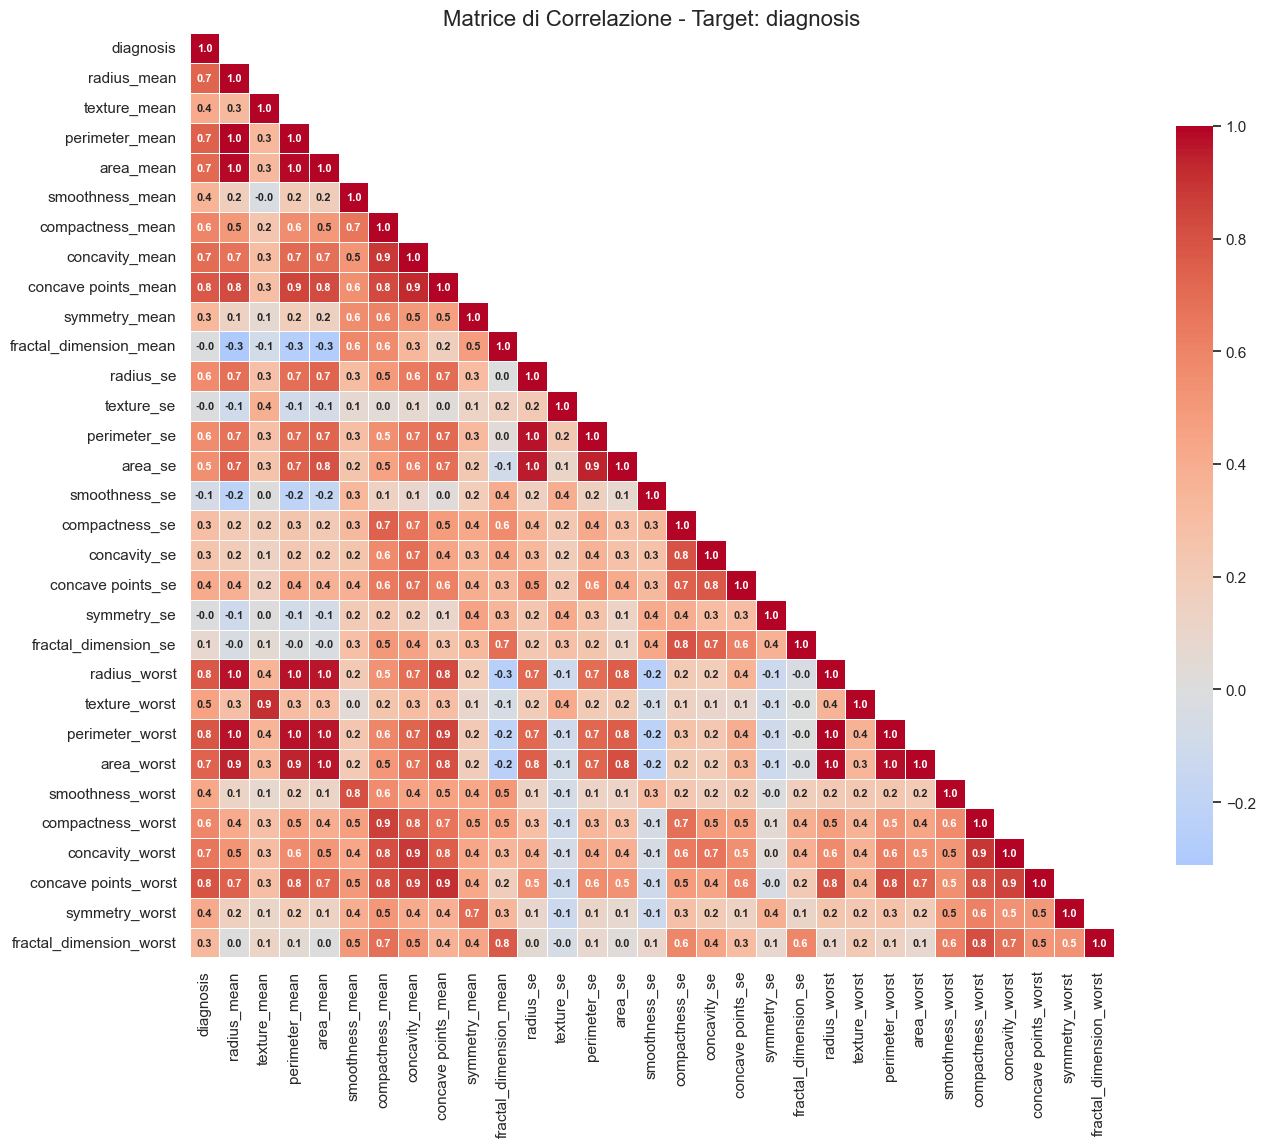

In [17]:
plot_correlation_matrix(df=df)

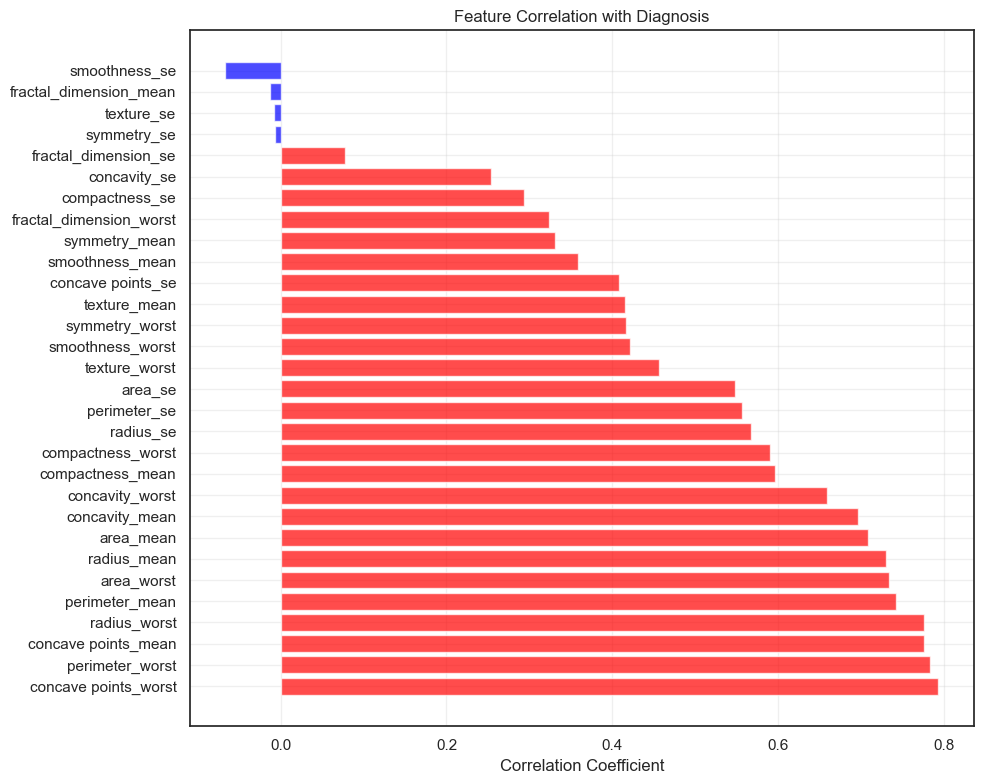

In [18]:
plt.figure(figsize=(10, 8))
corr_with_target = df.corr()[TARGET].drop(TARGET).sort_values(ascending=False)
colors = ['red' if x > 0 else 'blue' for x in corr_with_target.values]
plt.barh(range(len(corr_with_target)), corr_with_target.values, color=colors, alpha=0.7)
plt.yticks(range(len(corr_with_target)), corr_with_target.index)
plt.xlabel('Correlation Coefficient')
plt.title('Feature Correlation with Diagnosis')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# varianze feature numeriche
variances = df.var()

# correlazione assoluta con target
correlations = df.corr()[TARGET].abs()

stats_df = pd.DataFrame({
    'feature': variances.index,
    'variance': variances.values,
    'target_corr': correlations.values 
})

# feature com bassa varianza o scarsa correlazione con target
low_variance_or_corr_df = (
    stats_df[
        (stats_df['variance'] < 0.01) |
        (stats_df['target_corr'] < 0.1)
    ]
    .sort_values(by='target_corr')
)

low_variance_or_corr_df

,feature,variance,target_corr
19,symmetry_se,0.000068,0.006522
12,texture_se,0.304316,0.008303
10,fractal_dimension_mean,0.000050,0.012838
15,smoothness_se,0.000009,0.067016
20,fractal_dimension_se,0.000007,0.077972
17,concavity_se,0.000911,0.253730
16,compactness_se,0.000321,0.292999
30,fractal_dimension_worst,0.000326,0.323872
9,symmetry_mean,0.000752,0.330499
5,smoothness_mean,0.000198,0.358560


## Utility
Definizione funzioni per automatizzazione dell'esecuzione delle varie pipeline.

In [20]:
def fit_pipeline_to_df(pipeline, X_train, y_train, X_test, y_test):
    """
    Allena la pipeline e restituisce un DataFrame con metriche e matrice di confusione.
    """
    # fit e predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # metriche di validazione
    report = classification_report(y_test, y_pred, output_dict=True)

    # matrice di confusione
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results = {
        'modello': pipeline.named_steps['classifier'].__class__.__name__,
        'accuracy': report.get('accuracy'),
        'macro_precision': report.get('macro avg', {}).get('precision'),
        'macro_recall': report.get('macro avg', {}).get('recall'),
        'macro_f1': report.get('macro avg', {}).get('f1-score'),
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp
    }

    return pd.DataFrame([results])

In [21]:
def perform_cv_report(pipeline: Pipeline, X, y):
    """
    Valuta una pipeline tramite K-Fold-Cross-Validation calcolando diverse metriche.
    Restituisce un DataFrame con medie e deviazioni standard dei risultati.
    """
    # metriche
    scoring = {
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro'
    }

    # esecuzione cv
    scores = cross_validate(pipeline, X, y, cv=N_FOLDS, scoring=scoring, n_jobs=-1)

    # dizionario risultati
    results = {'modello': pipeline.named_steps['classifier'].__class__.__name__}

    # media e deviazione std per ogni metrica
    for metric_name in scoring.keys():
        metric_values = scores[f'test_{metric_name}']

        results[f'{metric_name}_mean'] = np.mean(metric_values)
        results[f'{metric_name}_std'] = np.std(metric_values)

    return pd.DataFrame([results])

In [22]:
def fine_tune_pipelines(pipeline: Pipeline, X, y, filename: str | Path):
    """
    Gestisce l'ottimizzazione degli iperparametri: se esiste un file JSON carica i
    risultati, altrimenti esegue GridSearchCV per ogni modello in models_dict.
    """
    filename = Path(filename)

    # caricamento parametri da file se tuning già fatto
    if filename.exists() and filename.is_file() and filename.stat().st_size > 0:
        print(f"--- File '{filename}' trovato. Caricamento parametri... ---")
        with open(filename, 'r') as f:
            return json.load(f)

    global models_dict, param_grids

    print(f"--- File '{filename}' non trovato. Avvio GridSearchCV... ---")
    best_params_report = {}

    for model_name, model in models_dict.items():
        print(f"Ottimizzazione per: {model_name}...")

        # modello corrente nella pipeline
        pipe = clone(pipeline)
        pipe.set_params(**{'classifier': model})

        # adattamento chiavi per step 'classifier' della pipeline
        raw_grid = param_grids[model_name]
        prefixed_grid = {f'classifier__{k}': v for k, v in raw_grid.items()}

        grid_search = GridSearchCV(
            estimator=pipe,
            param_grid=prefixed_grid,
            cv=N_FOLDS,
            scoring=GRID_SEARCH_CV_SCORING_DISCRIMINANT,
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X, y)

        # pulizia nomi parametri pre-salvataggio
        clean_best_params = {k.replace('classifier__', ''): v for k, v in grid_search.best_params_.items()}
        best_params_report[model_name] = clean_best_params

    # salvataggio risultati per evitare di fare tuning al prossimo avvio
    with open(filename, 'w') as f:
        json.dump(best_params_report, f, indent=4)

    print(f"--- Fine-Tuning completato. Parametri salvati in '{filename}' ---")
    return best_params_report

### Funzione wrap-up

In [23]:
def run_full_experiment(pipeline: Pipeline, X_train, y_train, X_test, y_test,
                         filename: str | Path | None = None):
    """
    Coordina l'intera pipeline di machine learning: valuta i modelli con parametri
    standard e, se richiesto, esegue il tuning per confrontare le performance migliorate.
    """
    results_default = []
    results_tuned = []
    fitted_models = {}
    global models_dict, param_grids

    #lista classificatori per logica soft voting
    default_estimators = []

    # modelli default
    print("Avvio valutazione modelli con i parametri di DEFAULT...")
    for model_name, model in models_dict.items():

        clf = clone(model)
        default_estimators.append((model_name, clf))

        pipe = clone(pipeline)
        pipe.set_params(**{'classifier': model})

        # k-fold cross validation
        res_cv = perform_cv_report(pipeline= pipe, X = X, y = y)

        # semplice fitting train-test split
        res_test = fit_pipeline_to_df(pipe, X_train, y_train, X_test, y_test)

        fitted_models[f"{model_name}_Default"] = copy.deepcopy(pipe)

        # unione risultati training e cv
        combined = pd.concat([res_test, res_cv.drop(columns='modello')], axis=1)
        combined.insert(1, 'configurazione', 'Default')
        results_default.append(combined)

    # logica ensemble voting
    print("Training Ensemble (Soft Voting) - Default")
    voting_clf = VotingClassifier(estimators=default_estimators, voting='soft')

    pipe_ensemble = clone(pipeline)
    pipe_ensemble.set_params(classifier=voting_clf)

    # valutazione Ensemble

    # k-fold cross validation
    res_cv = perform_cv_report(pipeline=pipe_ensemble, X = X, y = y)

    # semplice fitting train-test split
    res_test = fit_pipeline_to_df(pipe_ensemble, X_train, y_train, X_test, y_test)

    fitted_models["VotingClassifier_Default"] = copy.deepcopy(pipe_ensemble)

    # unione risultati
    combined = pd.concat([res_test, res_cv.drop(columns='modello')], axis=1)
    combined.insert(1, 'configurazione', 'Default')
    results_default.append(combined)

    # finetuning
    if filename is None:
        print("Errore: devi fornire un filename per il fine-tuning.")
        return pd.concat(results_default, ignore_index=True), pd.DataFrame()

    print(f"Avvio FINE-TUNING (o caricamento da {filename})...")

    # grid search con k-fold
    best_params_dict = fine_tune_pipelines(pipeline, X_train, y_train, filename)

    print("Valutazione modelli ottimizzati (TUNED)...")

    tuned_estimators = []

    for model_name, params in best_params_dict.items():
        clf = clone(models_dict[model_name])
        clf.set_params(**params)
        tuned_estimators.append((model_name, clf))

        pipe = clone(pipeline)
        pipe.set_params(**{'classifier': models_dict[model_name]})

        # configurazione iperparametri
        prefixed_params = {f'classifier__{k}': v for k, v in params.items()}
        pipe.set_params(**prefixed_params)

        # valutazione canonica su test set
        res_test = fit_pipeline_to_df(pipe, X_train, y_train, X_test, y_test)

        fitted_models[f"{model_name}_Tuned"] = copy.deepcopy(pipe)

        res_test.insert(1, 'configurazione', 'Tuned')
        results_tuned.append(res_test)

    # ensemble dei modelli tuned
    print("Training Ensemble (Soft Voting) - Tuned...")
    voting_clf_tuned = VotingClassifier(estimators=tuned_estimators, voting='soft')

    pipe_ensemble_tuned = clone(pipeline)
    pipe_ensemble_tuned.set_params(classifier=voting_clf_tuned)

    res_test = fit_pipeline_to_df(pipe_ensemble_tuned, X_train, y_train, X_test, y_test)
    fitted_models["VotingClassifier_Tuned"] = copy.deepcopy(pipe_ensemble_tuned)

    res_test.insert(1, 'configurazione', 'Tuned')
    results_tuned.append(res_test)

    return pd.concat(results_default, ignore_index=True), pd.concat(results_tuned, ignore_index=True), fitted_models

### Matrice di confusione
Visualizzazione matrici di confusione per analisi di TP, TN, FP e FN.

In [24]:
def plot_confusion_matrices_comparison(report_default, report_tuned, pipeline_name: str):
    """
    Crea una griglia di subplot con le matrici di confusione confrontando i due DataFrame.
    Ogni riga mostra il modello Default a sinistra e il modello Tuned a destra.
    """
    all_models = sorted(list(set(report_default['modello']).union(set(report_tuned['modello']))))

    num_models = len(all_models)
    if num_models == 0:
        print("Nessun dato trovato nei DataFrame forniti.")
        return

    # ogni riga ha 2 colonne - default e tuned
    n_cols = 2
    n_rows = num_models

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows), squeeze=False)
    fig.suptitle(f"Confronto Matrici di Confusione: Default vs Tuned ({pipeline_name})", fontsize=16, y=1.02)

    for i, model_name in enumerate(all_models):
        for j, (df_report, config_label) in enumerate([(report_default, 'Default'), (report_tuned, 'Tuned')]):
            ax = axes[i, j]

            row_data = df_report[df_report['modello'] == model_name]

            if not row_data.empty:
                row = row_data.iloc[0]

                # [[TP, FP],
                #  [FN, TN]]
                cm = np.array([
                    [row['true_positives'], row['false_positives']],
                    [row['false_negatives'], row['true_negatives']]
                ])

                # heatmap
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                            xticklabels=['Maligni', 'Benigni'],
                            yticklabels=['Maligni', 'Benigni'])

                ax.set_title(f"{model_name} ({config_label})", fontsize=12, fontweight='bold')
                ax.set_ylabel('Valori Predetti')
                ax.set_xlabel('Valori Reali')
            else:
                ax.axis('off')
                ax.set_title(f"{model_name} {config_label}\n(Dati non disponibili)", fontsize=10, color='gray')

    plt.tight_layout()
    plt.show()

## Explainability
Visualizzazione feature importance e struttura ad albero (solamente per modelli compatibili)

In [25]:
def plot_multiple_feature_importances(models_dict, pipeline_name="Basic Pipeline"):
    """
    Crea una griglia di plot per la feature importance di tutti i modelli nel dizionario
    che supportano questa funzionalità.
    """
    # modelli che hanno come attributo feature_importances
    base_model_names = sorted(list(set(k.split('_')[0] for k in models_dict.keys()
                                     if "Voting" not in k)))

    valid_base_models = []
    for name in base_model_names:
        has_default = hasattr(models_dict.get(f"{name}_Default", object()), 'named_steps') and \
                      hasattr(models_dict[f"{name}_Default"].named_steps['classifier'], 'feature_importances_')
        has_tuned = hasattr(models_dict.get(f"{name}_Tuned", object()), 'named_steps') and \
                    hasattr(models_dict[f"{name}_Tuned"].named_steps['classifier'], 'feature_importances_')

        if has_default or has_tuned:
            valid_base_models.append(name)

    n_models = len(valid_base_models)
    if n_models == 0:
        print(f"Nessun modello con feature importance trovato in {pipeline_name}.")
        return

    # ogni riga ha 2 colonne: default e tuned
    n_cols = 2
    n_rows = n_models

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
    fig.suptitle(f"Feature Importance - Origine: {pipeline_name}", fontsize=16, y=1.02)

    for row_idx, model_name in enumerate(valid_base_models):
        for col_idx, suffix in enumerate(["Default", "Tuned"]):
            key = f"{model_name}_{suffix}"
            ax = axes[row_idx, col_idx]

            if key not in models_dict:
                ax.axis('off')
                continue

            pipe = models_dict[key]
            clf = pipe.named_steps['classifier']

            if not hasattr(clf, 'feature_importances_'):
                ax.axis('off')
                continue

            importances = clf.feature_importances_

            # recupero del nome delle features
            try:
                # step -2 è quello prima del classificatore (es. PCA, Scaler, Selector), 1 indica l'oggetto della tupla e non il nome
                feature_names = pipe.steps[-2][1].get_feature_names_out()
            except:
                feature_names = [f"Feat_{i}" for i in range(len(importances))]

            df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
            df_imp = df_imp.sort_values(by='importance', ascending=False).head(15)
            # plot
            sns.barplot(data=df_imp, x='importance', y='feature', hue='feature',
                        palette='viridis', ax=ax, legend=False)

            ax.set_title(key, fontsize=12, fontweight='bold')
            ax.set_xlabel("Importance")
            ax.set_ylabel("")

    plt.tight_layout()
    plt.show()

In [26]:
def plot_multiple_trees(models_dict: dict, pipeline_name="Basic Pipeline"):
    """
    Crea una griglia di visualizzazione per tutti i DecisionTreeClassifier nel dizionario.
    """

    # lista di modelli che hanno effettivamente un albero come struttura di base
    base_model_names = sorted(list(set(k.rsplit('_', 1)[0] for k in models_dict.keys()
                                     if "Voting" not in k)))

    tree_types = (DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier)

    valid_base_models = []
    for name in base_model_names:
        is_tree = False
        # controlliamo se esiste almeno una versione (Default o Tuned) che sia un albero
        for suffix in ["Default", "Tuned"]:
            key = f"{name}_{suffix}"
            if key in models_dict:
                pipe = models_dict[key]
                # verifichiamo se la pipeline ha lo step 'classifier' ed è del tipo corretto
                if 'classifier' in pipe.named_steps:
                    if isinstance(pipe.named_steps['classifier'], tree_types):
                        is_tree = True
                        break

        if is_tree:
            valid_base_models.append(name)

    n_models = len(valid_base_models)
    if n_models == 0:
        print(f"Nessun modello basato su alberi trovato in {pipeline_name}.")
        return

    # ogni riga hadue colonne: default e tuned
    n_cols = 2
    n_rows = n_models

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10 * n_rows), squeeze=False)
    fig.suptitle(f"Struttura Alberi (o singolo estimatore) - Origine: {pipeline_name}", fontsize=18, y=1.01)

    for row_idx, model_name in enumerate(valid_base_models):
        for col_idx, suffix in enumerate(["Default", "Tuned"]):
            key = f"{model_name}_{suffix}"
            ax = axes[row_idx, col_idx]

            if key not in models_dict:
                ax.axis('off')
                continue

            pipe = models_dict[key]
            clf = pipe.named_steps['classifier']

            if not isinstance(clf, tree_types):
                ax.axis('off')
                continue

            subtitle = ""
            tree_to_plot = None

            if isinstance(clf, DecisionTreeClassifier):
                tree_to_plot = clf
                subtitle = "Intero albero decisionale"

            elif isinstance(clf, RandomForestClassifier):
                tree_to_plot = clf.estimators_[0]
                subtitle = f"Estratto albero 1 di {clf.n_estimators}"

            elif isinstance(clf, GradientBoostingClassifier):
                tree_to_plot = clf.estimators_[0, 0]
                subtitle = f"Estratto albero 1 di {clf.n_estimators}"

            try:
                # step -2 è quello prima del classificatore, 1 prende l'oggetto effettivo della tupla
                feature_names = pipe.steps[-2][1].get_feature_names_out()
            except:
                feature_names = None

            # plot
            plot_tree(tree_to_plot,
                      filled=True,
                      feature_names=feature_names,
                      class_names=['Benigno', 'Maligno'],
                      rounded=True,
                      fontsize=9,
                      max_depth=2,
                      ax=ax)

            ax.set_title(f"{key}\n({subtitle})", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

## Train-test split
Metodo di pareto: 80% training set, 20% test set

In [27]:
y = df[TARGET]
X = df.drop(columns=TARGET)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

## Studio delle componenti per applicazione PCA

In [29]:
pca = PCA().fit(StandardScaler().fit_transform(X_train))
explained = pca.explained_variance_ratio_

total_var = 0.0
n_components = 0

while total_var < CUMULATIVE_PCA_VARIANCE_THRESHOLD:
    total_var += explained[n_components]
    n_components += 1

print(f"Con {n_components} componenti si ottiene variance_explained: {total_var * 100}%")

Con 7 componenti si ottiene variance_explained: 91.14245416254099%


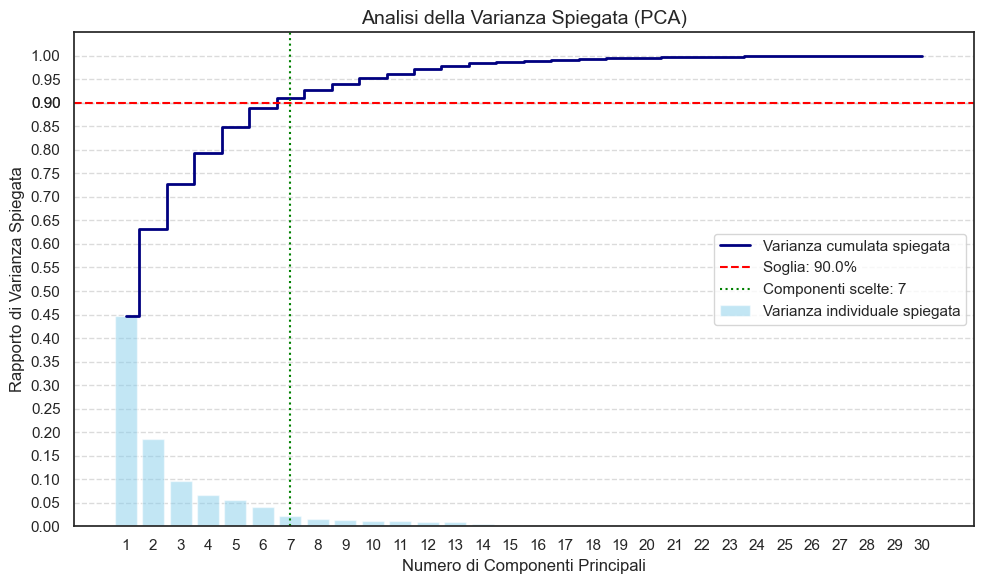

In [30]:
# visualizzazione grafico per varianza cumulata spiegata 
# all'aumentare del numero delle componenti
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained) + 1), explained, alpha=0.5, align='center',
        label='Varianza individuale spiegata', color='skyblue')
plt.step(range(1, len(explained) + 1), np.cumsum(explained), where='mid',
         label='Varianza cumulata spiegata', color='navy', linewidth=2)
plt.axhline(y=CUMULATIVE_PCA_VARIANCE_THRESHOLD, color='red', linestyle='--',
            label=f'Soglia: {CUMULATIVE_PCA_VARIANCE_THRESHOLD*100}%')
plt.axvline(x=n_components, color='green', linestyle=':',
            label=f'Componenti scelte: {n_components}')
plt.title('Analisi della Varianza Spiegata (PCA)', fontsize=14)
plt.xlabel('Numero di Componenti Principali', fontsize=12)
plt.ylabel('Rapporto di Varianza Spiegata', fontsize=12)
plt.xticks(range(1, len(explained) + 1))
ticks = list(np.arange(0, 1.01, 0.05)) + [CUMULATIVE_PCA_VARIANCE_THRESHOLD]
plt.yticks(ticks)
plt.legend(loc='center right')
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

Aggiornamento pipeline con PCA con le n_components precedentemente ricavate.

In [31]:
params = {'pca__n_components': n_components}
pipe_smote_pca.set_params(**params)

,steps,"[('scaler', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,sampling_strategy,0.8
,random_state,42
,k_neighbors,5
,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",7


## Avvio pipeline
Per ogni **pipeline** definita (Basic, SMOTE, PCA) e per ogni modello si esegue:
* training con i parametri di default del modello (**Default**).
* `GridSearchCV` per trovare la combinazione ottimale di iperparametri

Le metriche di validazione finali vengono salvate per un confronto finale.

In [32]:
report_basic_default, report_basic_tuned, models_basic = run_full_experiment(pipelines_dict['basic'], X_train, y_train, X_test, y_test, filename=BASIC_HYPERPARAMETERS_PATH)

Avvio valutazione modelli con i parametri di DEFAULT...
Training Ensemble (Soft Voting) - Default
Avvio FINE-TUNING (o caricamento da hyperparameters\basic_hyperparameters.json)...
--- File 'hyperparameters\basic_hyperparameters.json' trovato. Caricamento parametri... ---
Valutazione modelli ottimizzati (TUNED)...
Training Ensemble (Soft Voting) - Tuned...


## Visualizzazione risultati pipeline
Le metriche di validazione utilizzati per i modelli **Default** sono relative a:
* semplice train-test split (accuracy, precision, recall, f1-score).
* k-fold cross validation (medie e deviazioni standard).
Per i modelli **Tuned** vengono mostrate le metriche di validazione applicate al test set.

### Risultati Pipeline Basic

In [33]:
report_basic_default

,modello,configurazione,accuracy,macro_precision,macro_recall,macro_f1,true_negatives,false_positives,false_negatives,true_positives,accuracy_mean,accuracy_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std,f1_macro_mean,f1_macro_std
0,SVC,Default,0.973684,0.980000,0.964286,0.971277,72,0,3,39,0.973638,0.014679,0.973487,0.013695,0.970417,0.018158,0.971677,0.015876
1,DecisionTreeClassifier,Default,0.929825,0.924603,0.924603,0.924603,68,4,4,38,0.917342,0.024195,0.912352,0.027128,0.915921,0.019672,0.912548,0.024415
2,RandomForestClassifier,Default,0.973684,0.980000,0.964286,0.971277,72,0,3,39,0.956094,0.022839,0.955992,0.023372,0.950794,0.025779,0.952824,0.024352
3,GradientBoostingClassifier,Default,0.964912,0.973684,0.952381,0.961486,72,0,4,38,0.961372,0.023899,0.960576,0.025926,0.957826,0.024355,0.958743,0.025115
4,VotingClassifier,Default,0.973684,0.980000,0.964286,0.971277,72,0,3,39,0.963111,0.021030,0.962466,0.023454,0.960132,0.020931,0.960652,0.022058


In [34]:
report_basic_tuned

,modello,configurazione,accuracy,macro_precision,macro_recall,macro_f1,true_negatives,false_positives,false_negatives,true_positives
0,SVC,Tuned,0.973684,0.980000,0.964286,0.971277,72,0,3,39
1,DecisionTreeClassifier,Tuned,0.929825,0.941239,0.909722,0.922051,71,1,7,35
2,RandomForestClassifier,Tuned,0.973684,0.980000,0.964286,0.971277,72,0,3,39
3,GradientBoostingClassifier,Tuned,0.964912,0.973684,0.952381,0.961486,72,0,4,38
4,VotingClassifier,Tuned,0.964912,0.973684,0.952381,0.961486,72,0,4,38


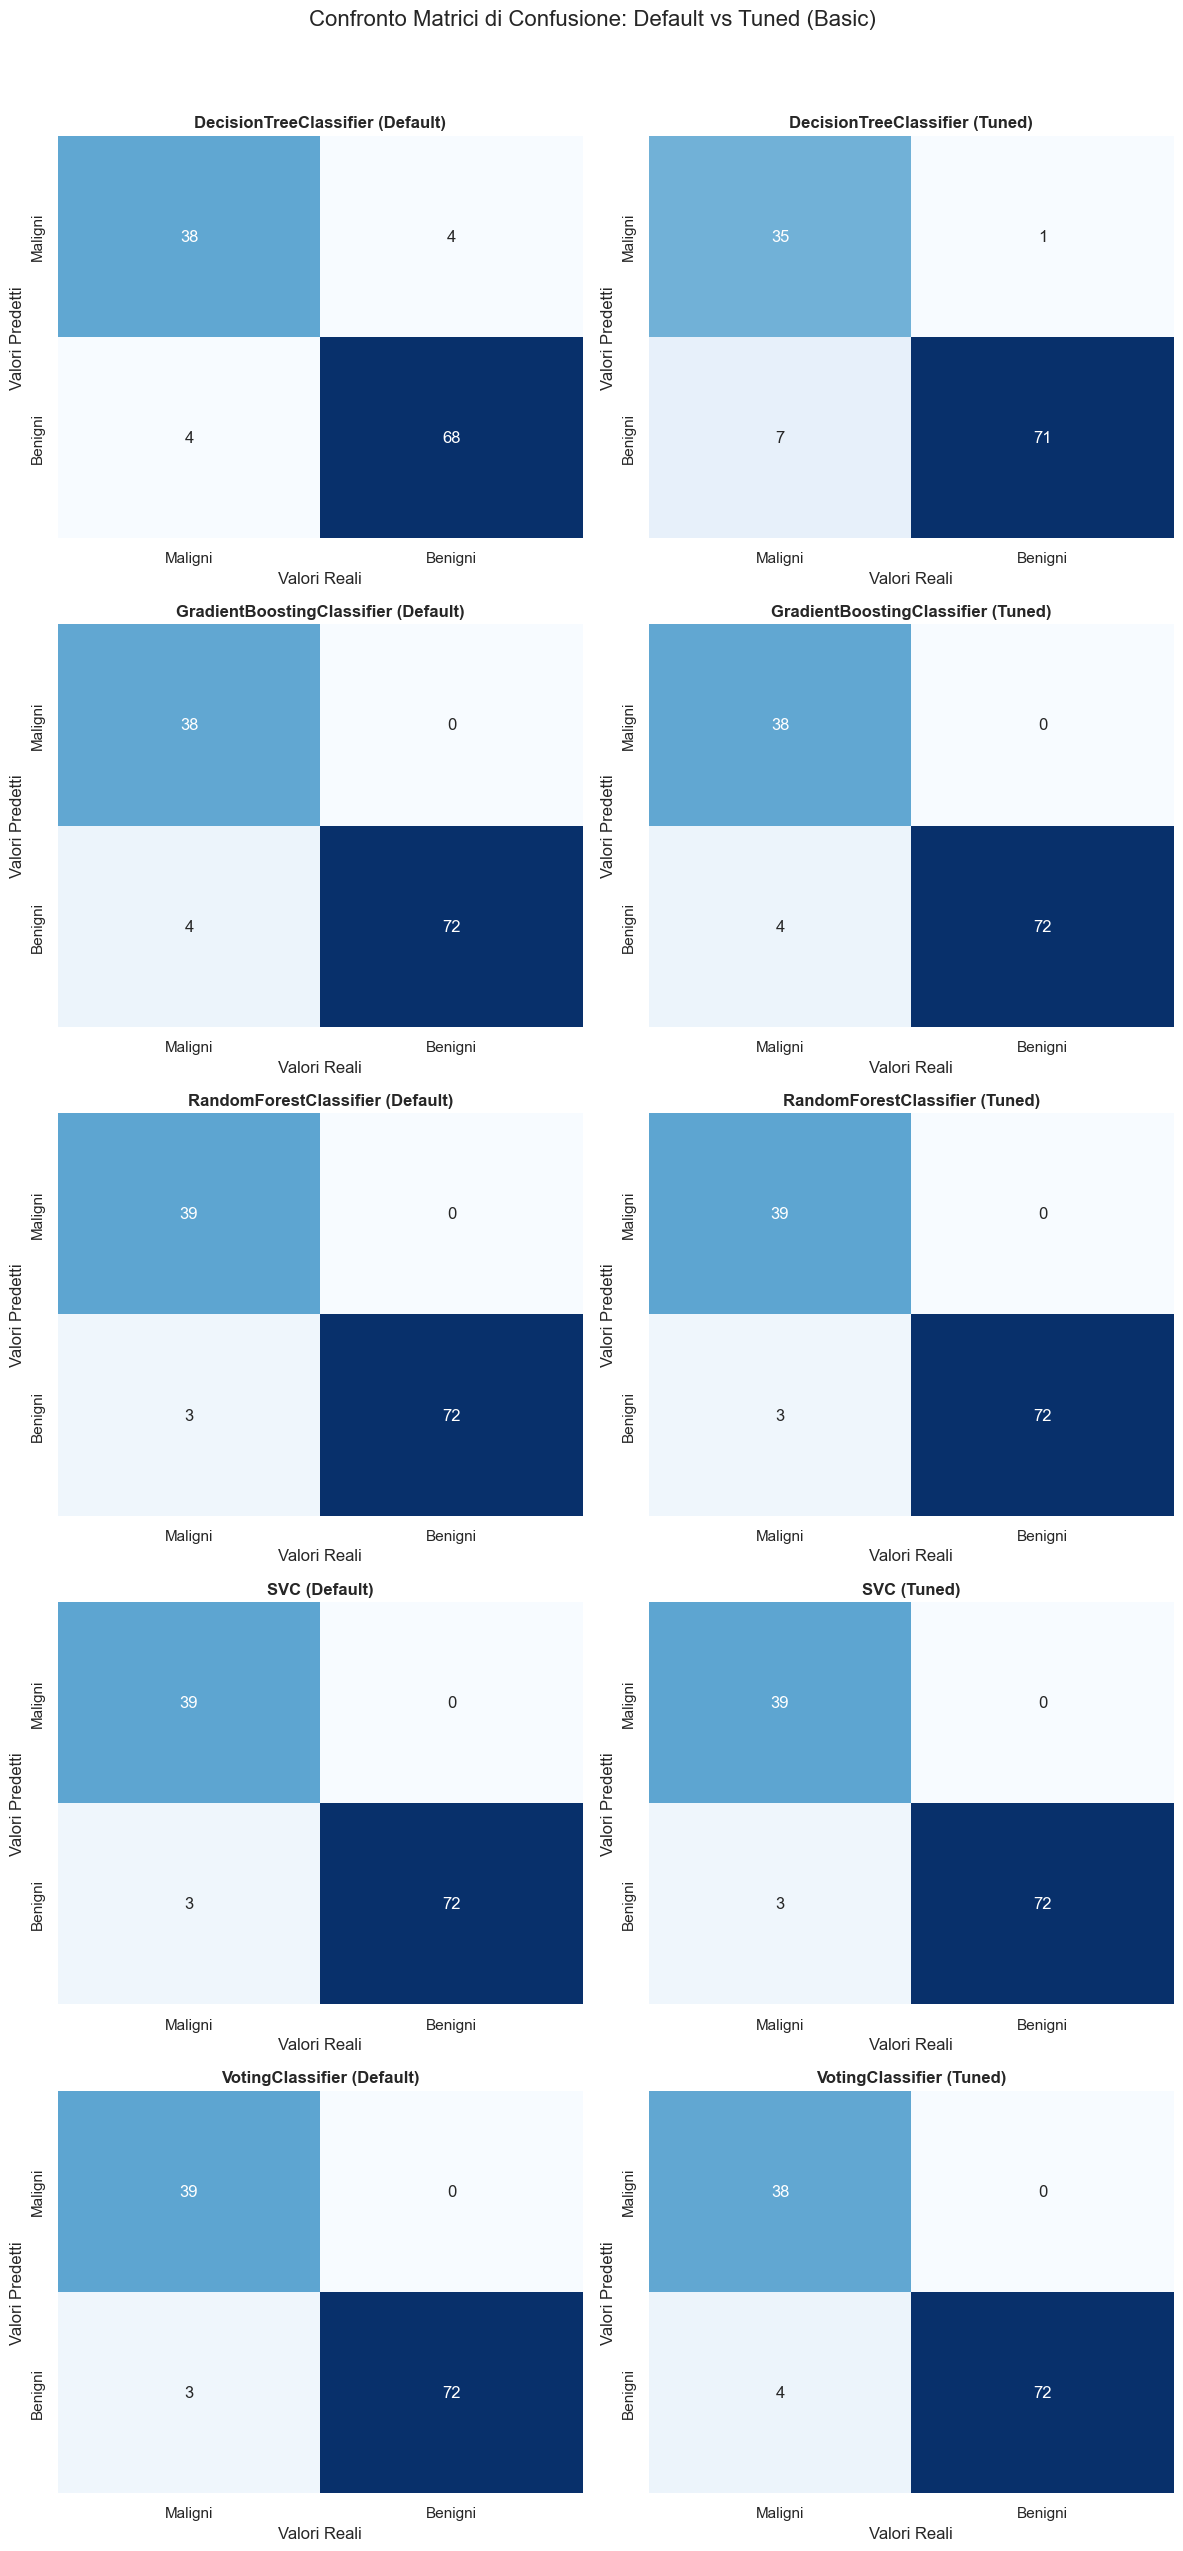

In [35]:
plot_confusion_matrices_comparison(
    report_default=report_basic_default,
    report_tuned=report_basic_tuned,
    pipeline_name='Basic'
)

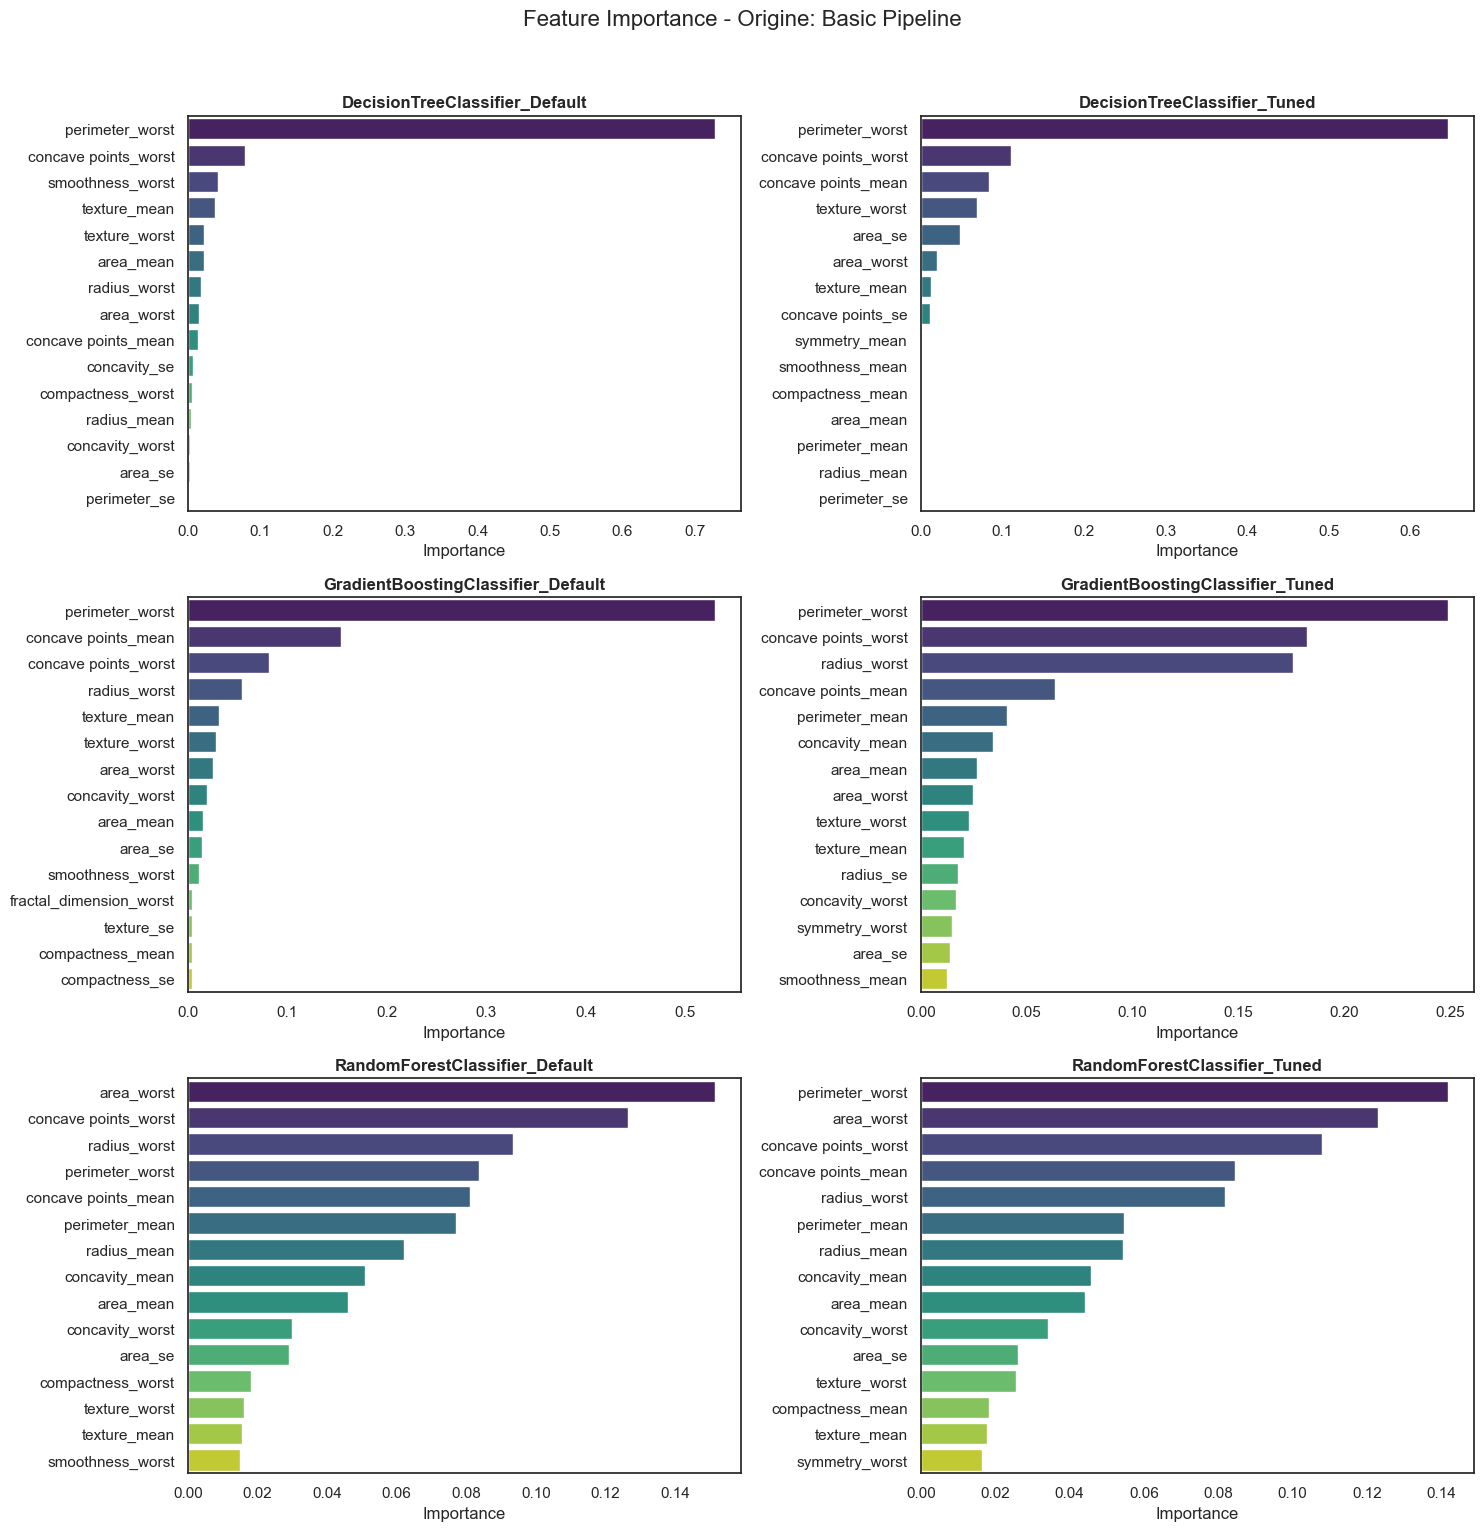

In [36]:
plot_multiple_feature_importances(models_dict = models_basic, pipeline_name="Basic Pipeline")

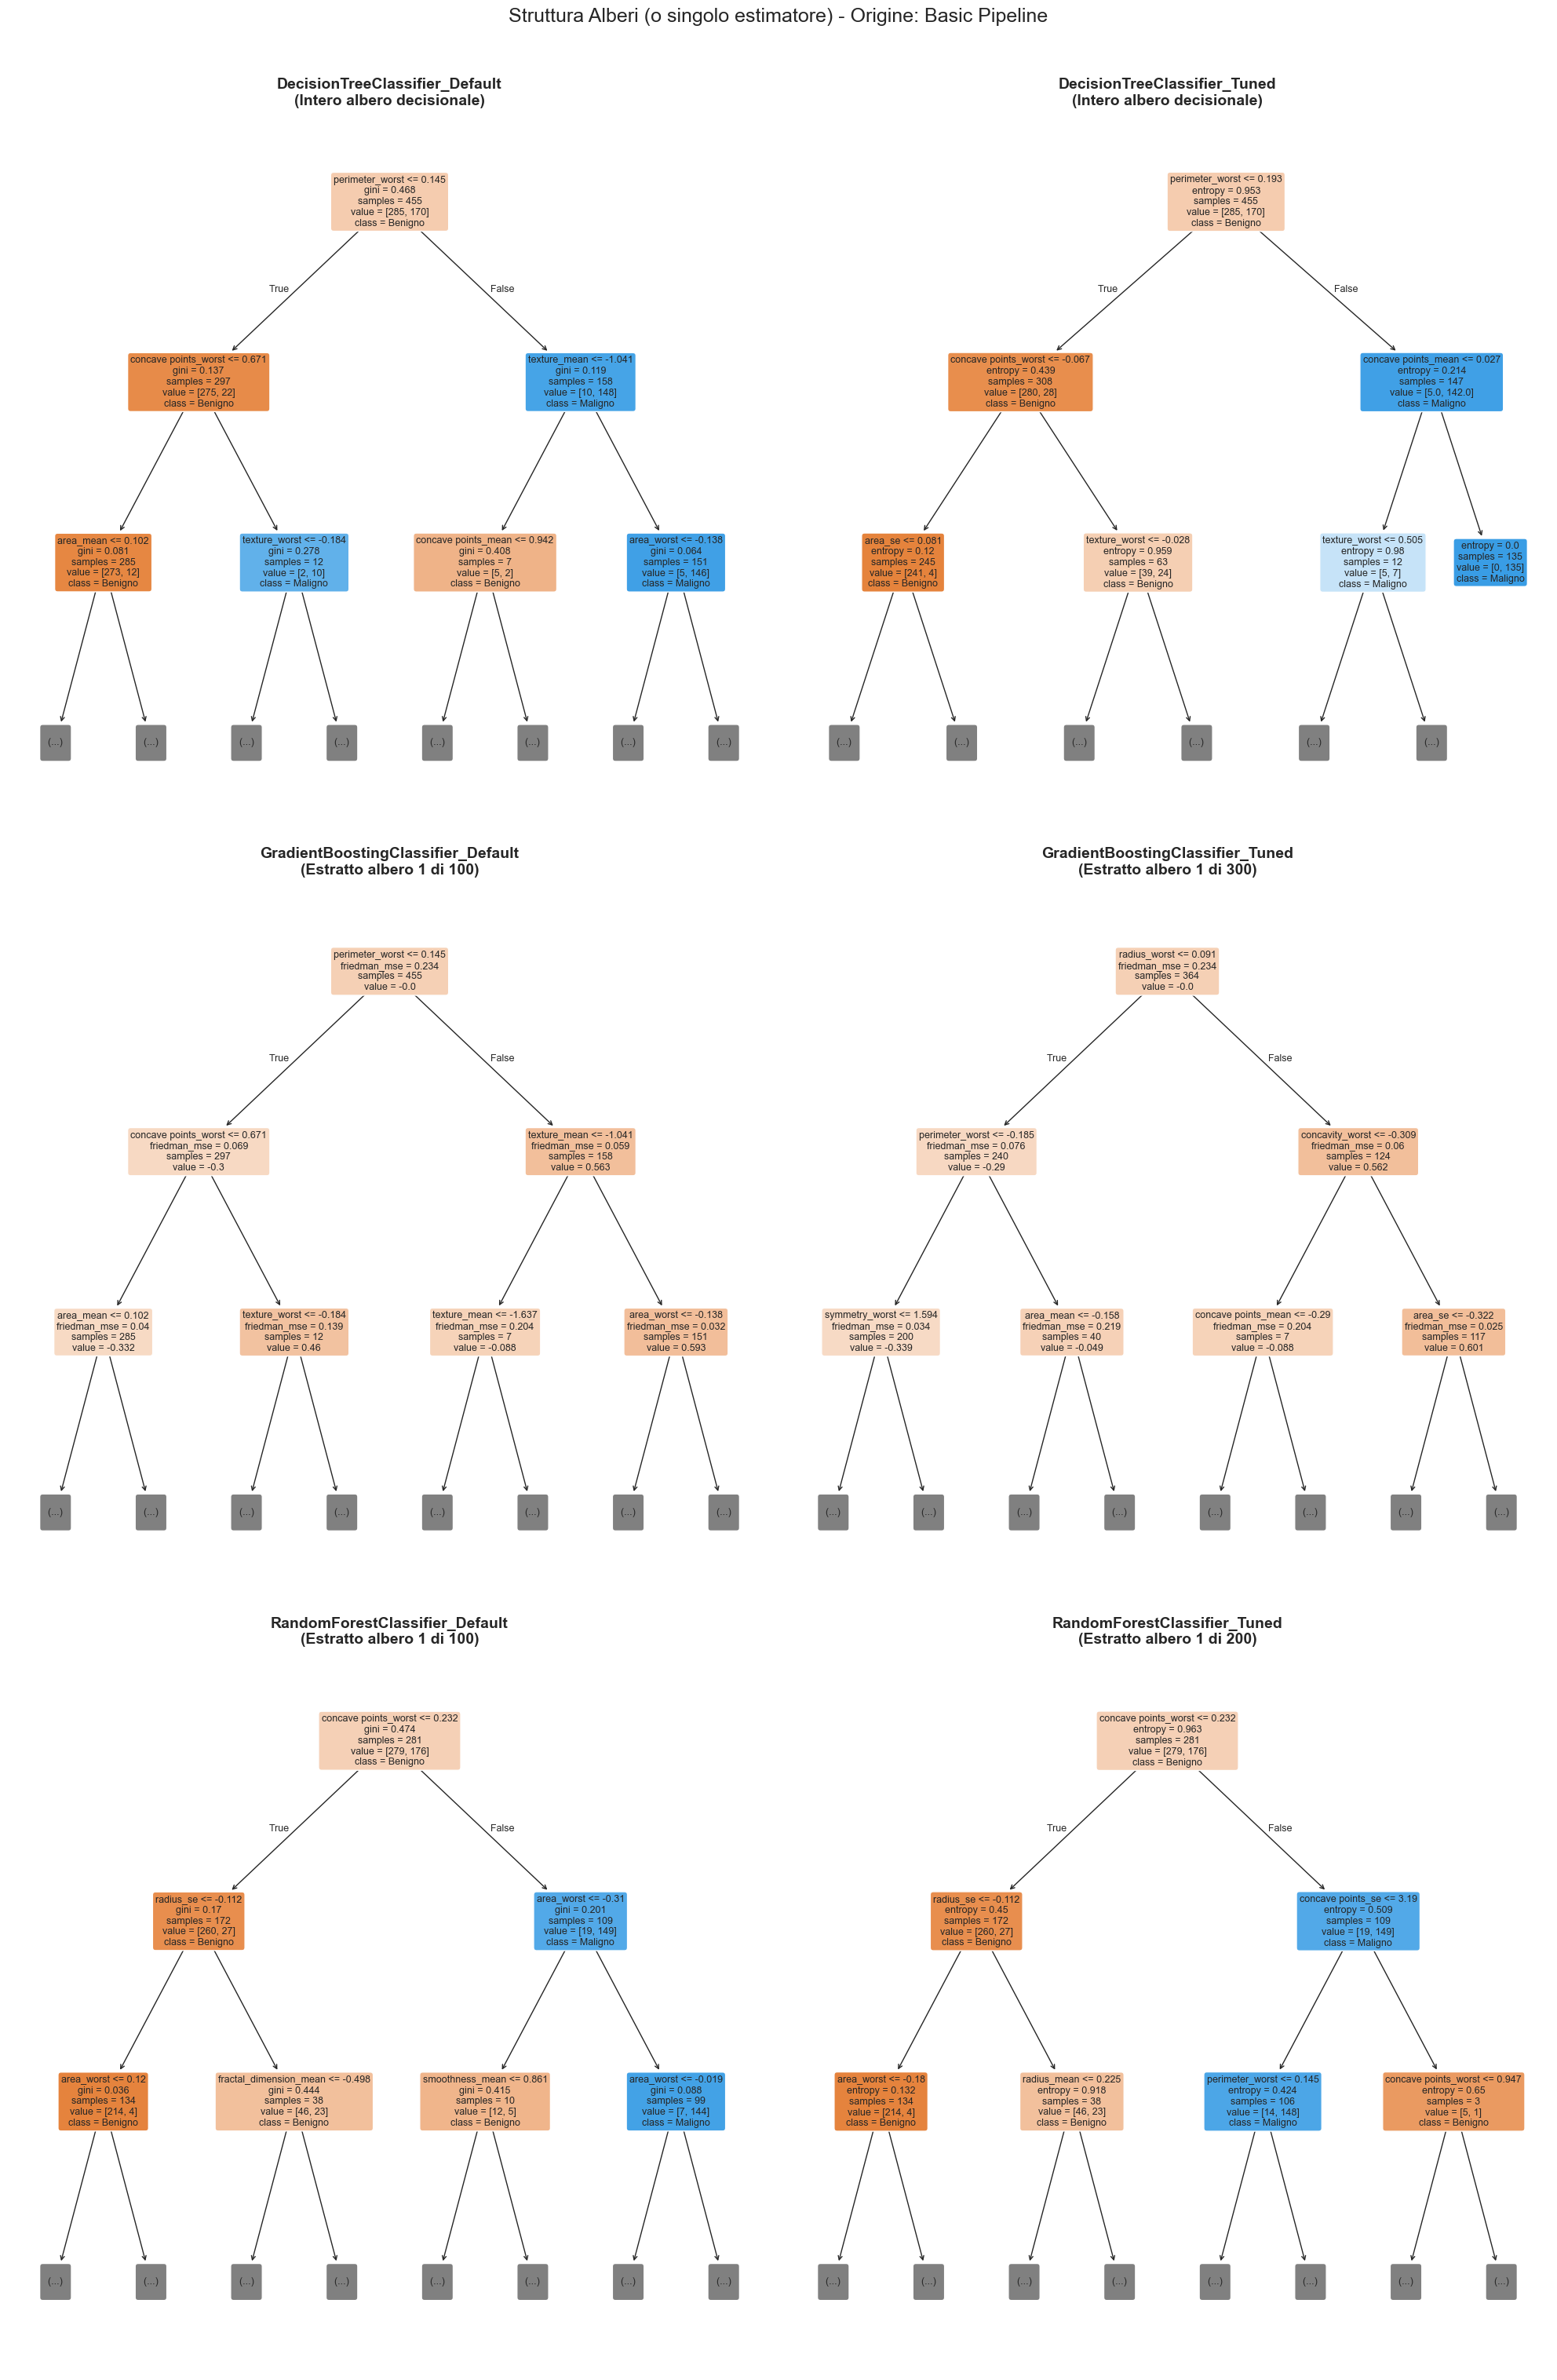

In [37]:
plot_multiple_trees(models_dict=models_basic, pipeline_name="Basic Pipeline")

### Risultati Pipeline Feature Selection + SMOTE


In [38]:
report_select_smote_default, report_select_smote_tuned, models_select_smote = run_full_experiment(
    pipeline=pipelines_dict['select_smote'],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    filename=SMOTE_HYPERPARAMETERS_PATH
)

Avvio valutazione modelli con i parametri di DEFAULT...
Training Ensemble (Soft Voting) - Default
Avvio FINE-TUNING (o caricamento da hyperparameters\smote_hyperparameters.json)...
--- File 'hyperparameters\smote_hyperparameters.json' trovato. Caricamento parametri... ---
Valutazione modelli ottimizzati (TUNED)...
Training Ensemble (Soft Voting) - Tuned...


In [39]:
report_select_smote_default

,modello,configurazione,accuracy,macro_precision,macro_recall,macro_f1,true_negatives,false_positives,false_negatives,true_positives,accuracy_mean,accuracy_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std,f1_macro_mean,f1_macro_std
0,SVC,Default,0.973684,0.980000,0.964286,0.971277,72,0,3,39,0.970160,0.016249,0.968425,0.018570,0.968517,0.016294,0.968205,0.017115
1,DecisionTreeClassifier,Default,0.956140,0.960513,0.945437,0.952129,71,1,4,38,0.938519,0.014586,0.936059,0.016711,0.934004,0.017763,0.934118,0.015624
2,RandomForestClassifier,Default,0.964912,0.967230,0.957341,0.961911,71,1,3,39,0.971883,0.014030,0.971311,0.014348,0.969064,0.016390,0.969893,0.014971
3,GradientBoostingClassifier,Default,0.964912,0.973684,0.952381,0.961486,72,0,4,38,0.966620,0.012867,0.965465,0.014815,0.963886,0.013409,0.964330,0.013553
4,VotingClassifier,Default,0.973684,0.980000,0.964286,0.971277,72,0,3,39,0.968374,0.010503,0.966990,0.011543,0.966267,0.012859,0.966192,0.011202


In [40]:
report_select_smote_tuned

,modello,configurazione,accuracy,macro_precision,macro_recall,macro_f1,true_negatives,false_positives,false_negatives,true_positives
0,SVC,Tuned,0.973684,0.980000,0.964286,0.971277,72,0,3,39
1,DecisionTreeClassifier,Tuned,0.921053,0.916973,0.912698,0.914749,68,4,5,37
2,RandomForestClassifier,Tuned,0.973684,0.980000,0.964286,0.971277,72,0,3,39
3,GradientBoostingClassifier,Tuned,0.973684,0.980000,0.964286,0.971277,72,0,3,39
4,VotingClassifier,Tuned,0.982456,0.986486,0.976190,0.980956,72,0,2,40


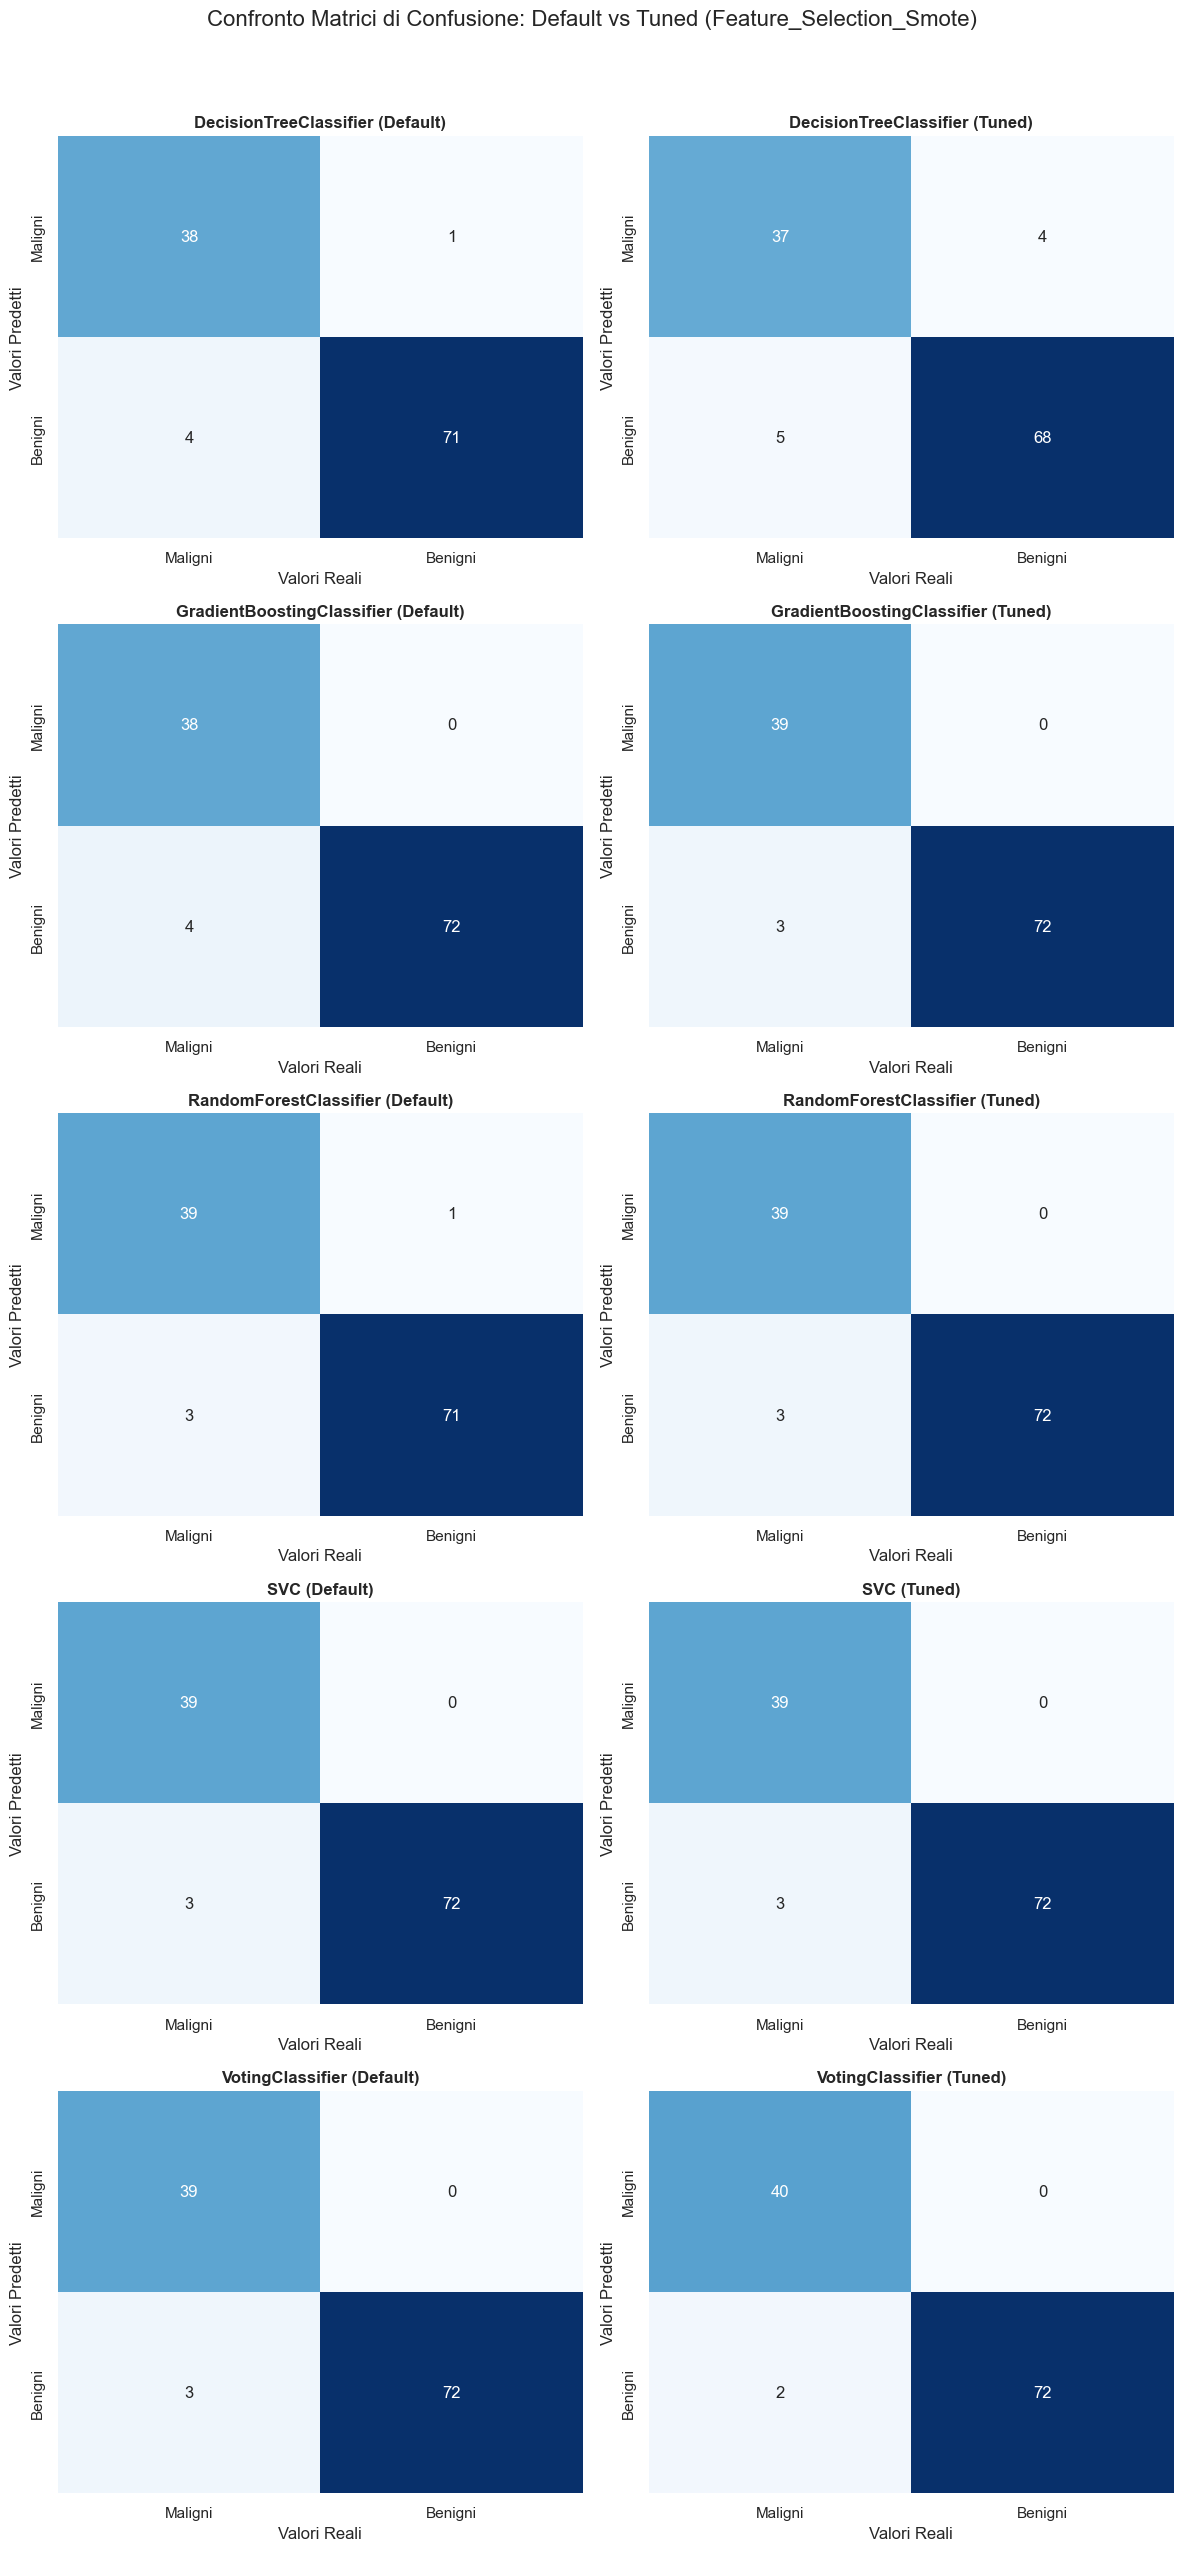

In [41]:
plot_confusion_matrices_comparison(
    report_default=report_select_smote_default,
    report_tuned=report_select_smote_tuned,
    pipeline_name='Feature_Selection_Smote'
)

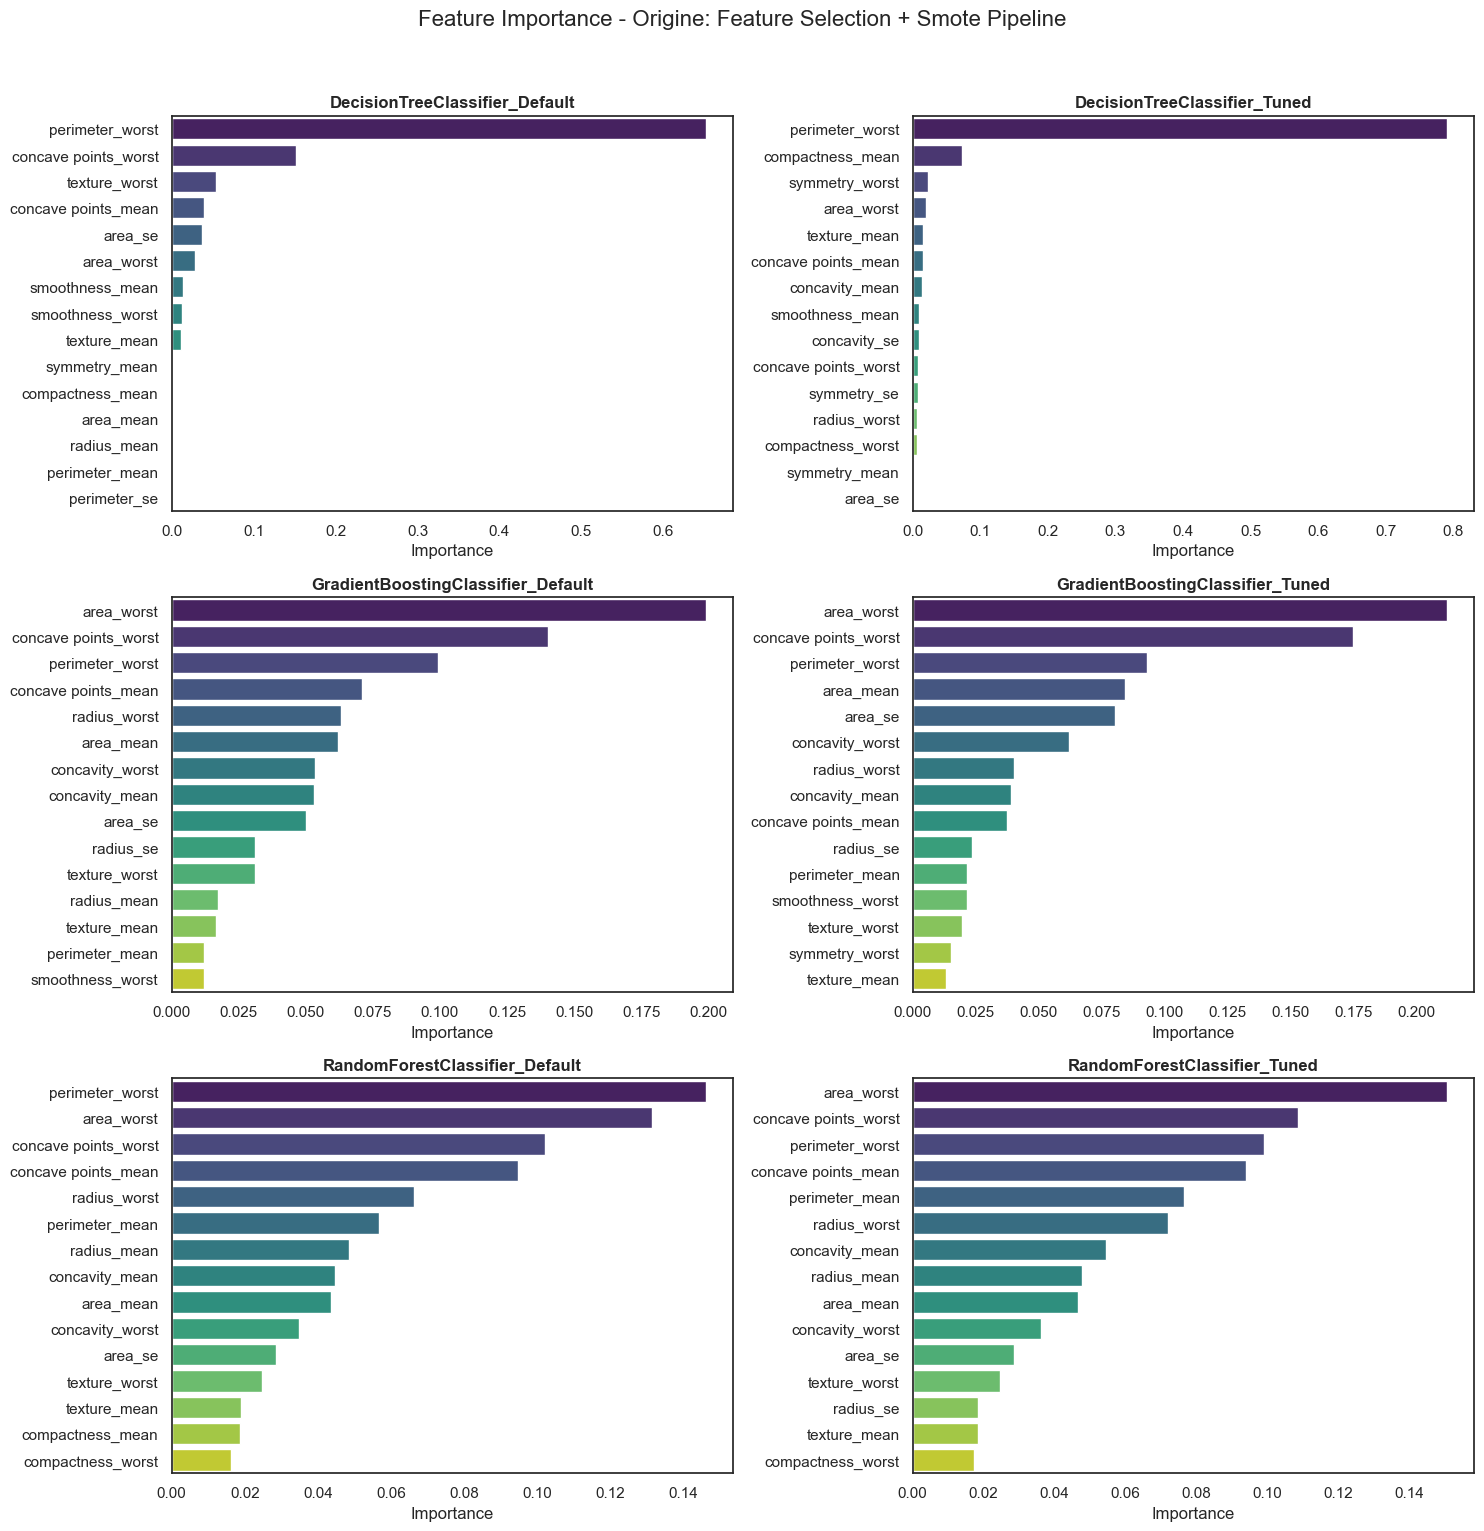

In [42]:
plot_multiple_feature_importances(models_dict=models_select_smote, pipeline_name='Feature Selection + Smote Pipeline')

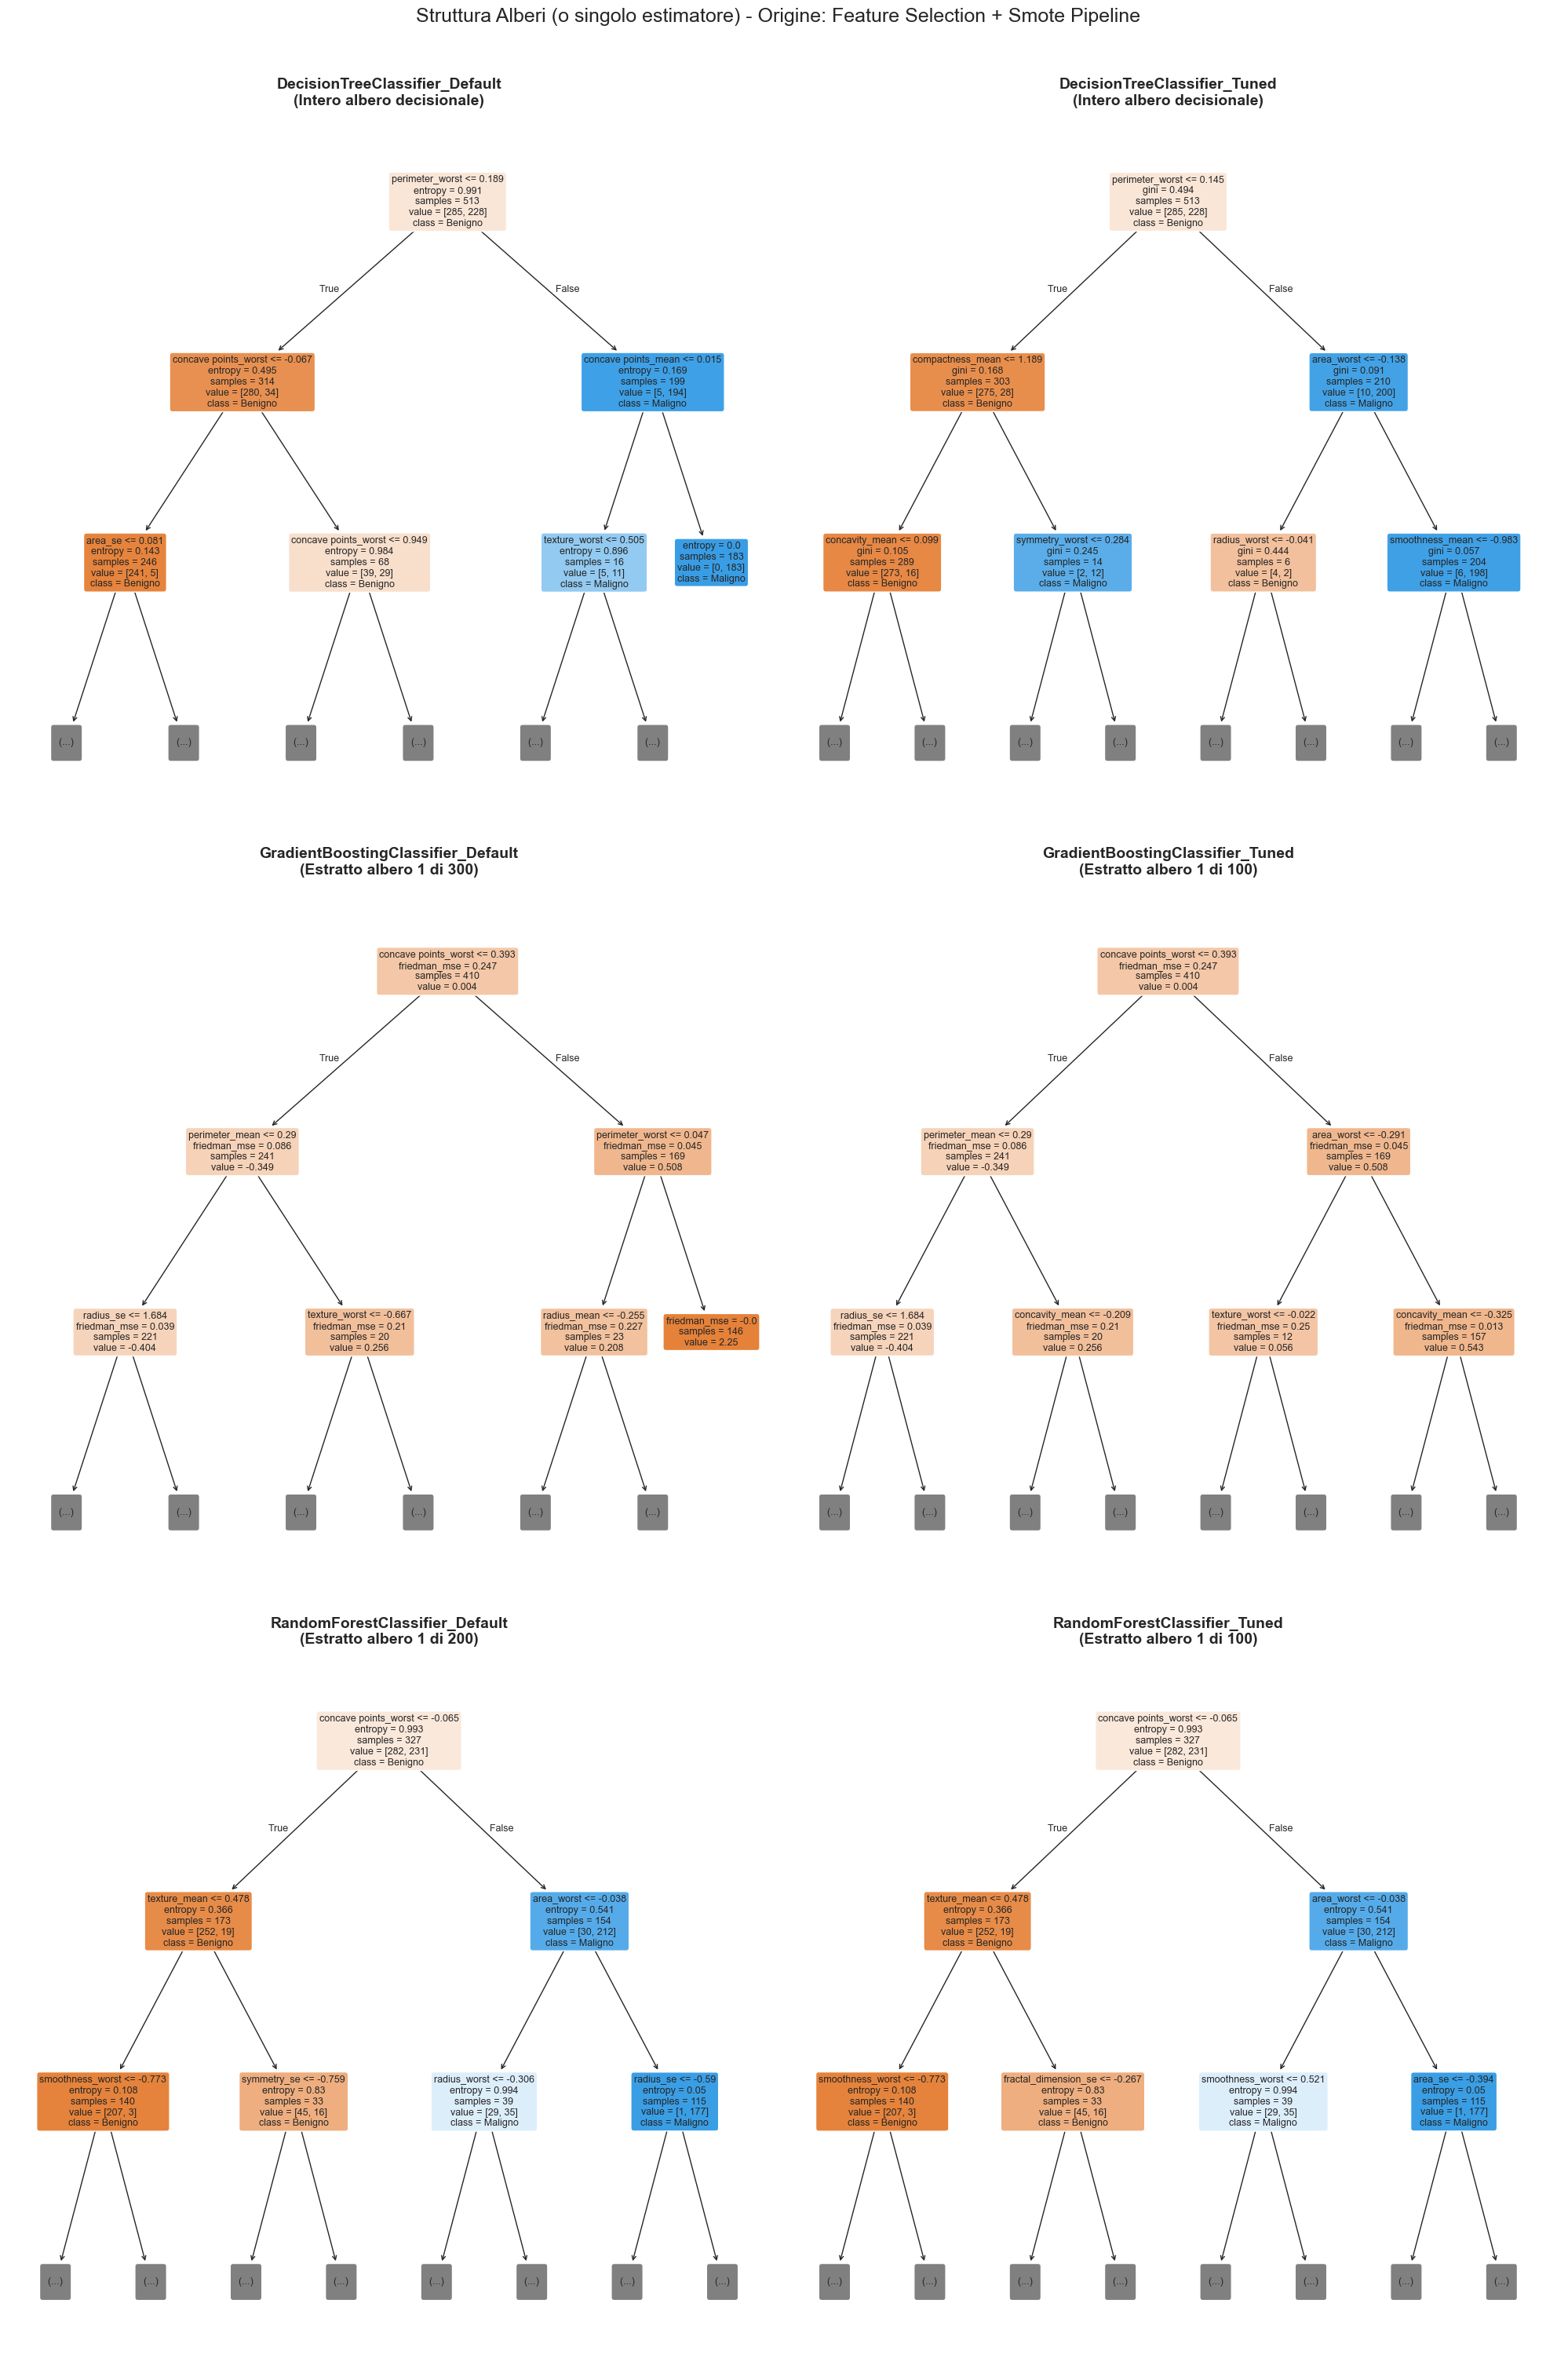

In [43]:
plot_multiple_trees(models_dict=models_select_smote, pipeline_name='Feature Selection + Smote Pipeline')

### Risultati Pipeline SMOTE + PCA


In [44]:
report_smote_pca_basic, report_smote_pca_tuned, models_smote_pca = run_full_experiment(
    pipeline=pipelines_dict['smote_pca'],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    filename=PCA_HYPERPARAMETERS_PATH
)

Avvio valutazione modelli con i parametri di DEFAULT...
Training Ensemble (Soft Voting) - Default
Avvio FINE-TUNING (o caricamento da hyperparameters\pca_hyperparameters.json)...
--- File 'hyperparameters\pca_hyperparameters.json' trovato. Caricamento parametri... ---
Valutazione modelli ottimizzati (TUNED)...
Training Ensemble (Soft Voting) - Tuned...


In [45]:
report_smote_pca_basic

,modello,configurazione,accuracy,macro_precision,macro_recall,macro_f1,true_negatives,false_positives,false_negatives,true_positives,accuracy_mean,accuracy_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std,f1_macro_mean,f1_macro_std
0,SVC,Default,0.964912,0.967230,0.957341,0.961911,71,1,3,39,0.968374,0.006983,0.969279,0.008214,0.963274,0.008279,0.965974,0.007455
1,DecisionTreeClassifier,Default,0.894737,0.886905,0.886905,0.886905,66,6,6,36,0.882161,0.050711,0.876501,0.053190,0.877299,0.050024,0.874908,0.052851
2,RandomForestClassifier,Default,0.938596,0.936017,0.931548,0.933693,69,3,4,38,0.949014,0.015169,0.945673,0.018728,0.946903,0.012303,0.945767,0.015572
3,GradientBoostingClassifier,Default,0.947368,0.947973,0.938492,0.942867,70,2,4,38,0.956032,0.014809,0.952936,0.018808,0.954352,0.011340,0.953248,0.015252
4,VotingClassifier,Default,0.956140,0.960513,0.945437,0.952129,71,1,4,38,0.961326,0.013161,0.958530,0.016263,0.959550,0.010416,0.958835,0.013566


In [46]:
report_smote_pca_tuned

,modello,configurazione,accuracy,macro_precision,macro_recall,macro_f1,true_negatives,false_positives,false_negatives,true_positives
0,SVC,Tuned,0.973684,0.974106,0.969246,0.971583,71,1,2,40
1,DecisionTreeClassifier,Tuned,0.929825,0.928716,0.919643,0.923822,69,3,5,37
2,RandomForestClassifier,Tuned,0.947368,0.947973,0.938492,0.942867,70,2,4,38
3,GradientBoostingClassifier,Tuned,0.947368,0.947973,0.938492,0.942867,70,2,4,38
4,VotingClassifier,Tuned,0.956140,0.955062,0.950397,0.952638,70,2,3,39


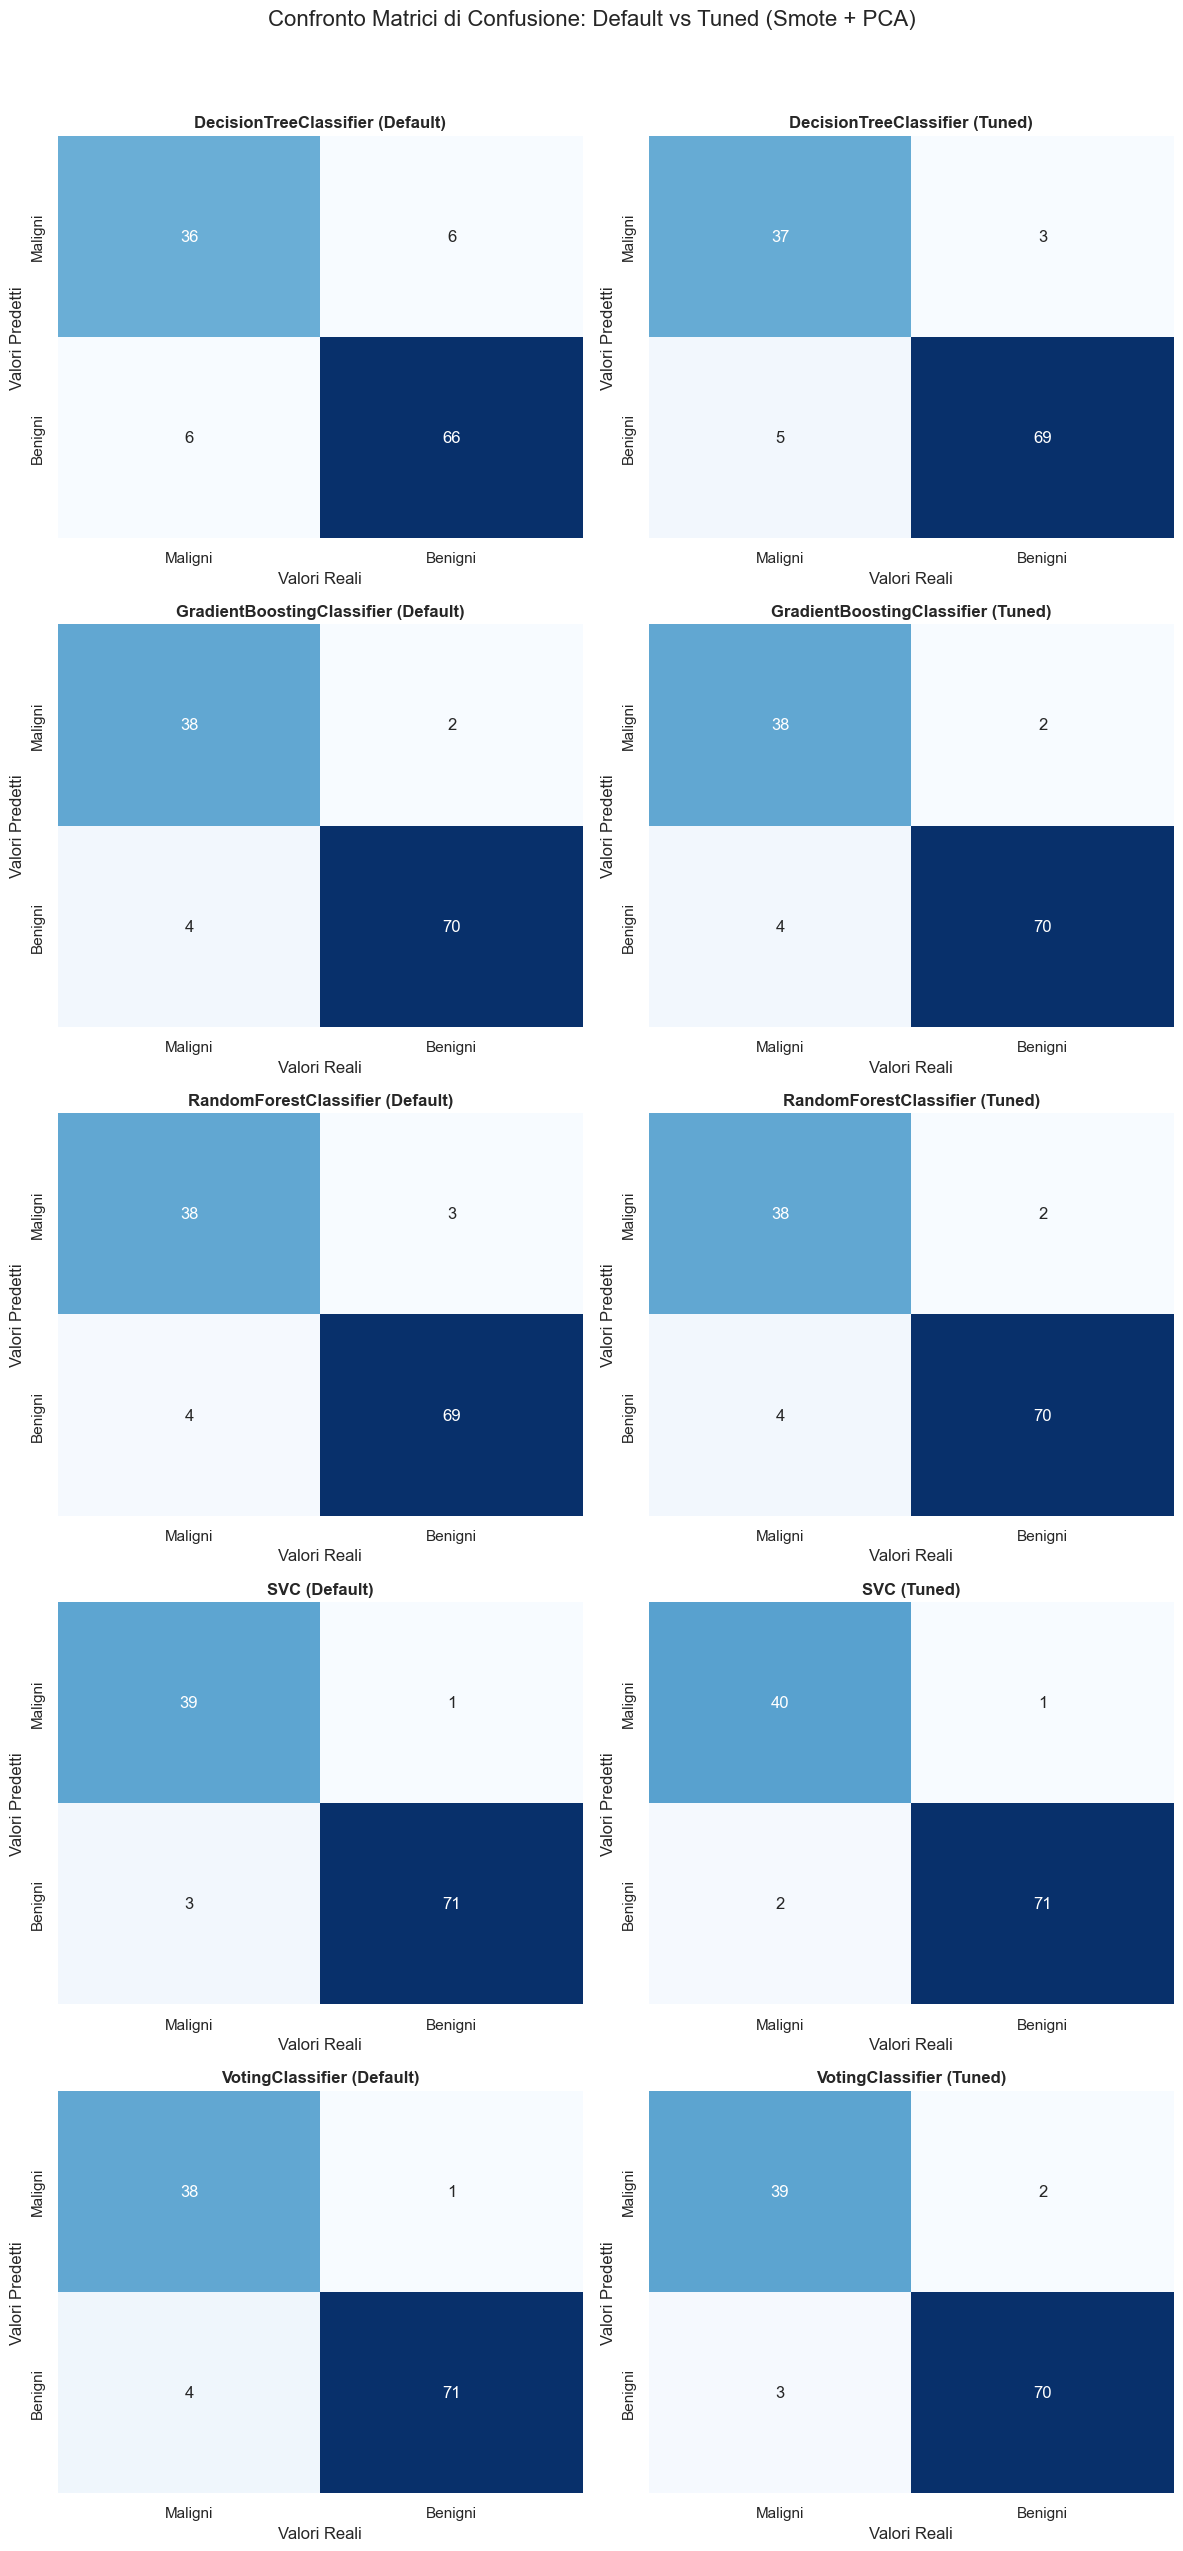

In [47]:
plot_confusion_matrices_comparison(
    report_default=report_smote_pca_basic,
    report_tuned=report_smote_pca_tuned,
    pipeline_name='Smote + PCA'
)

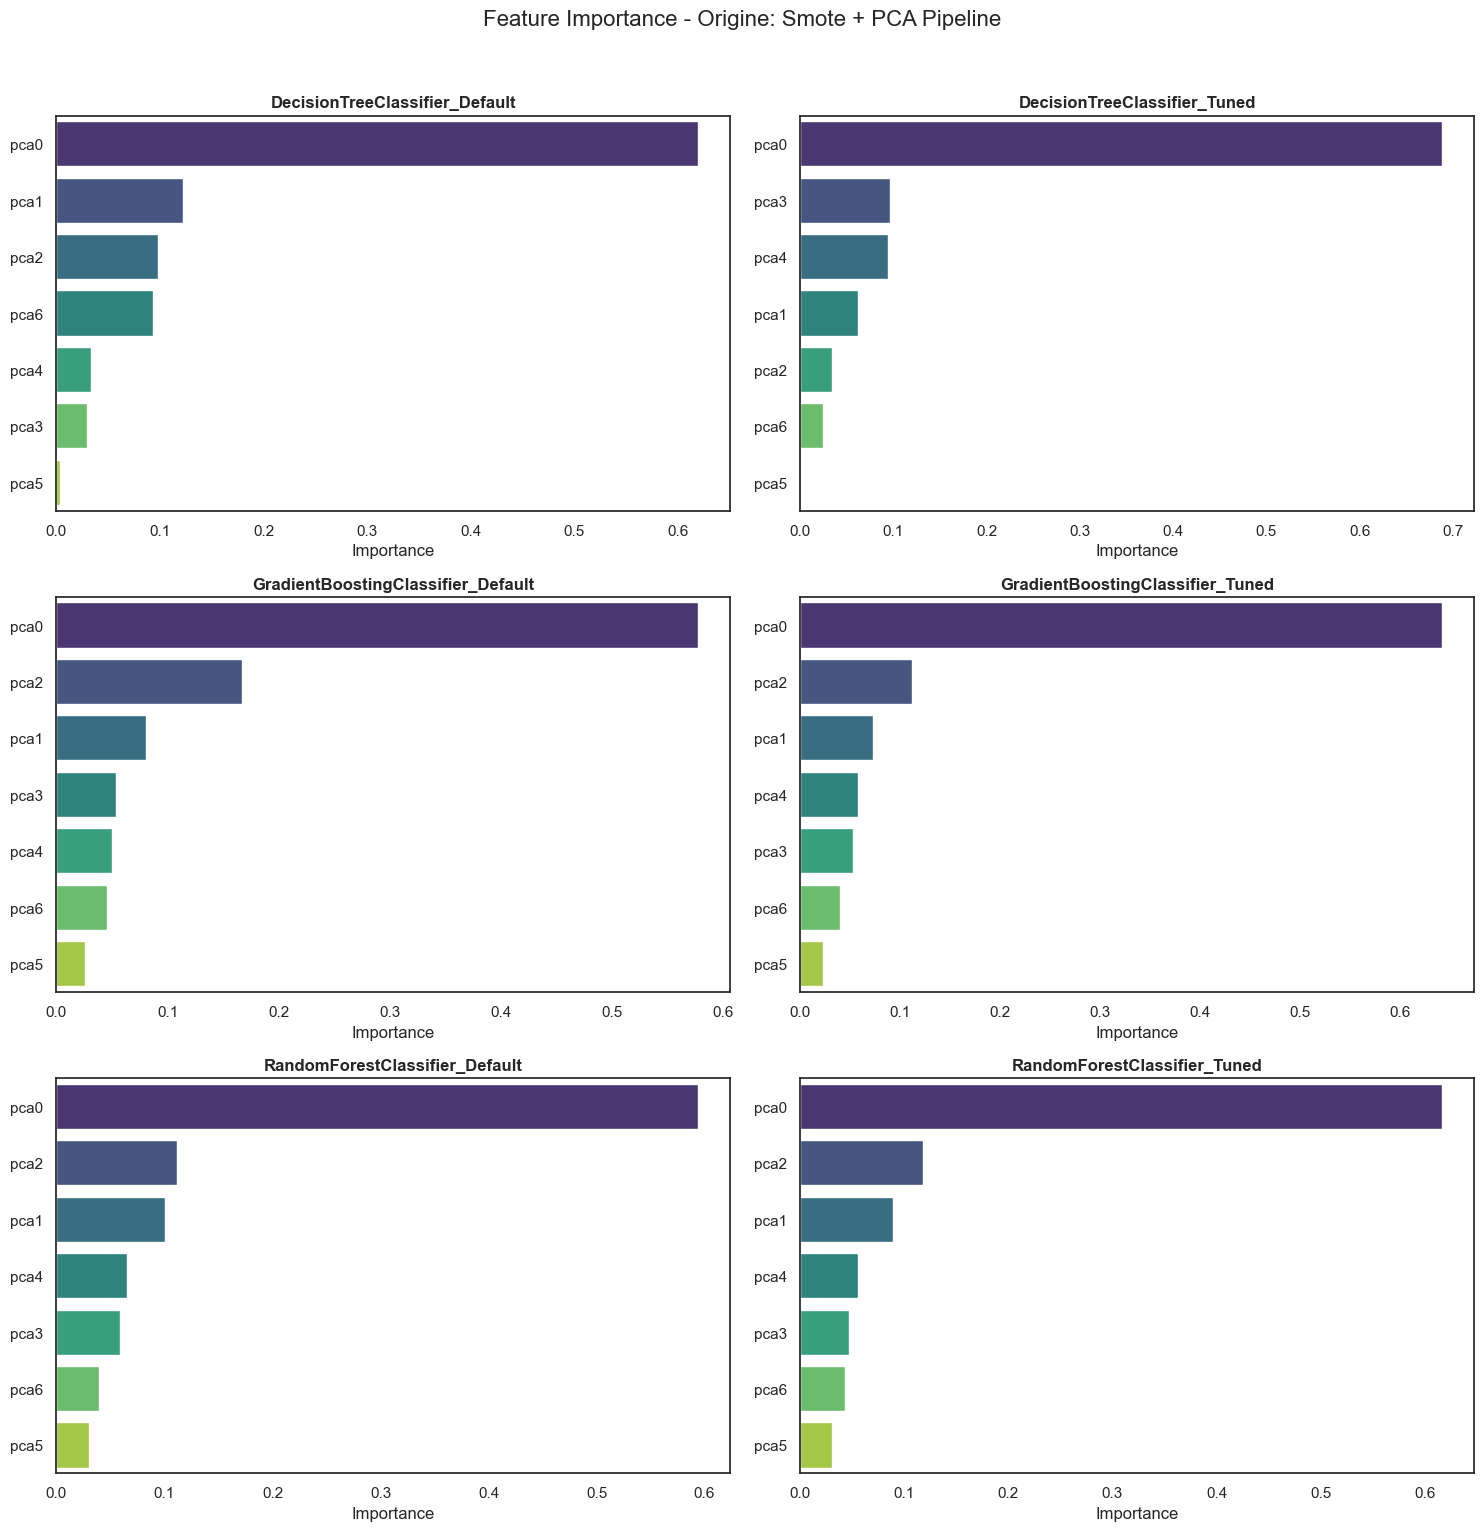

In [48]:
plot_multiple_feature_importances(models_dict=models_smote_pca, pipeline_name='Smote + PCA Pipeline')

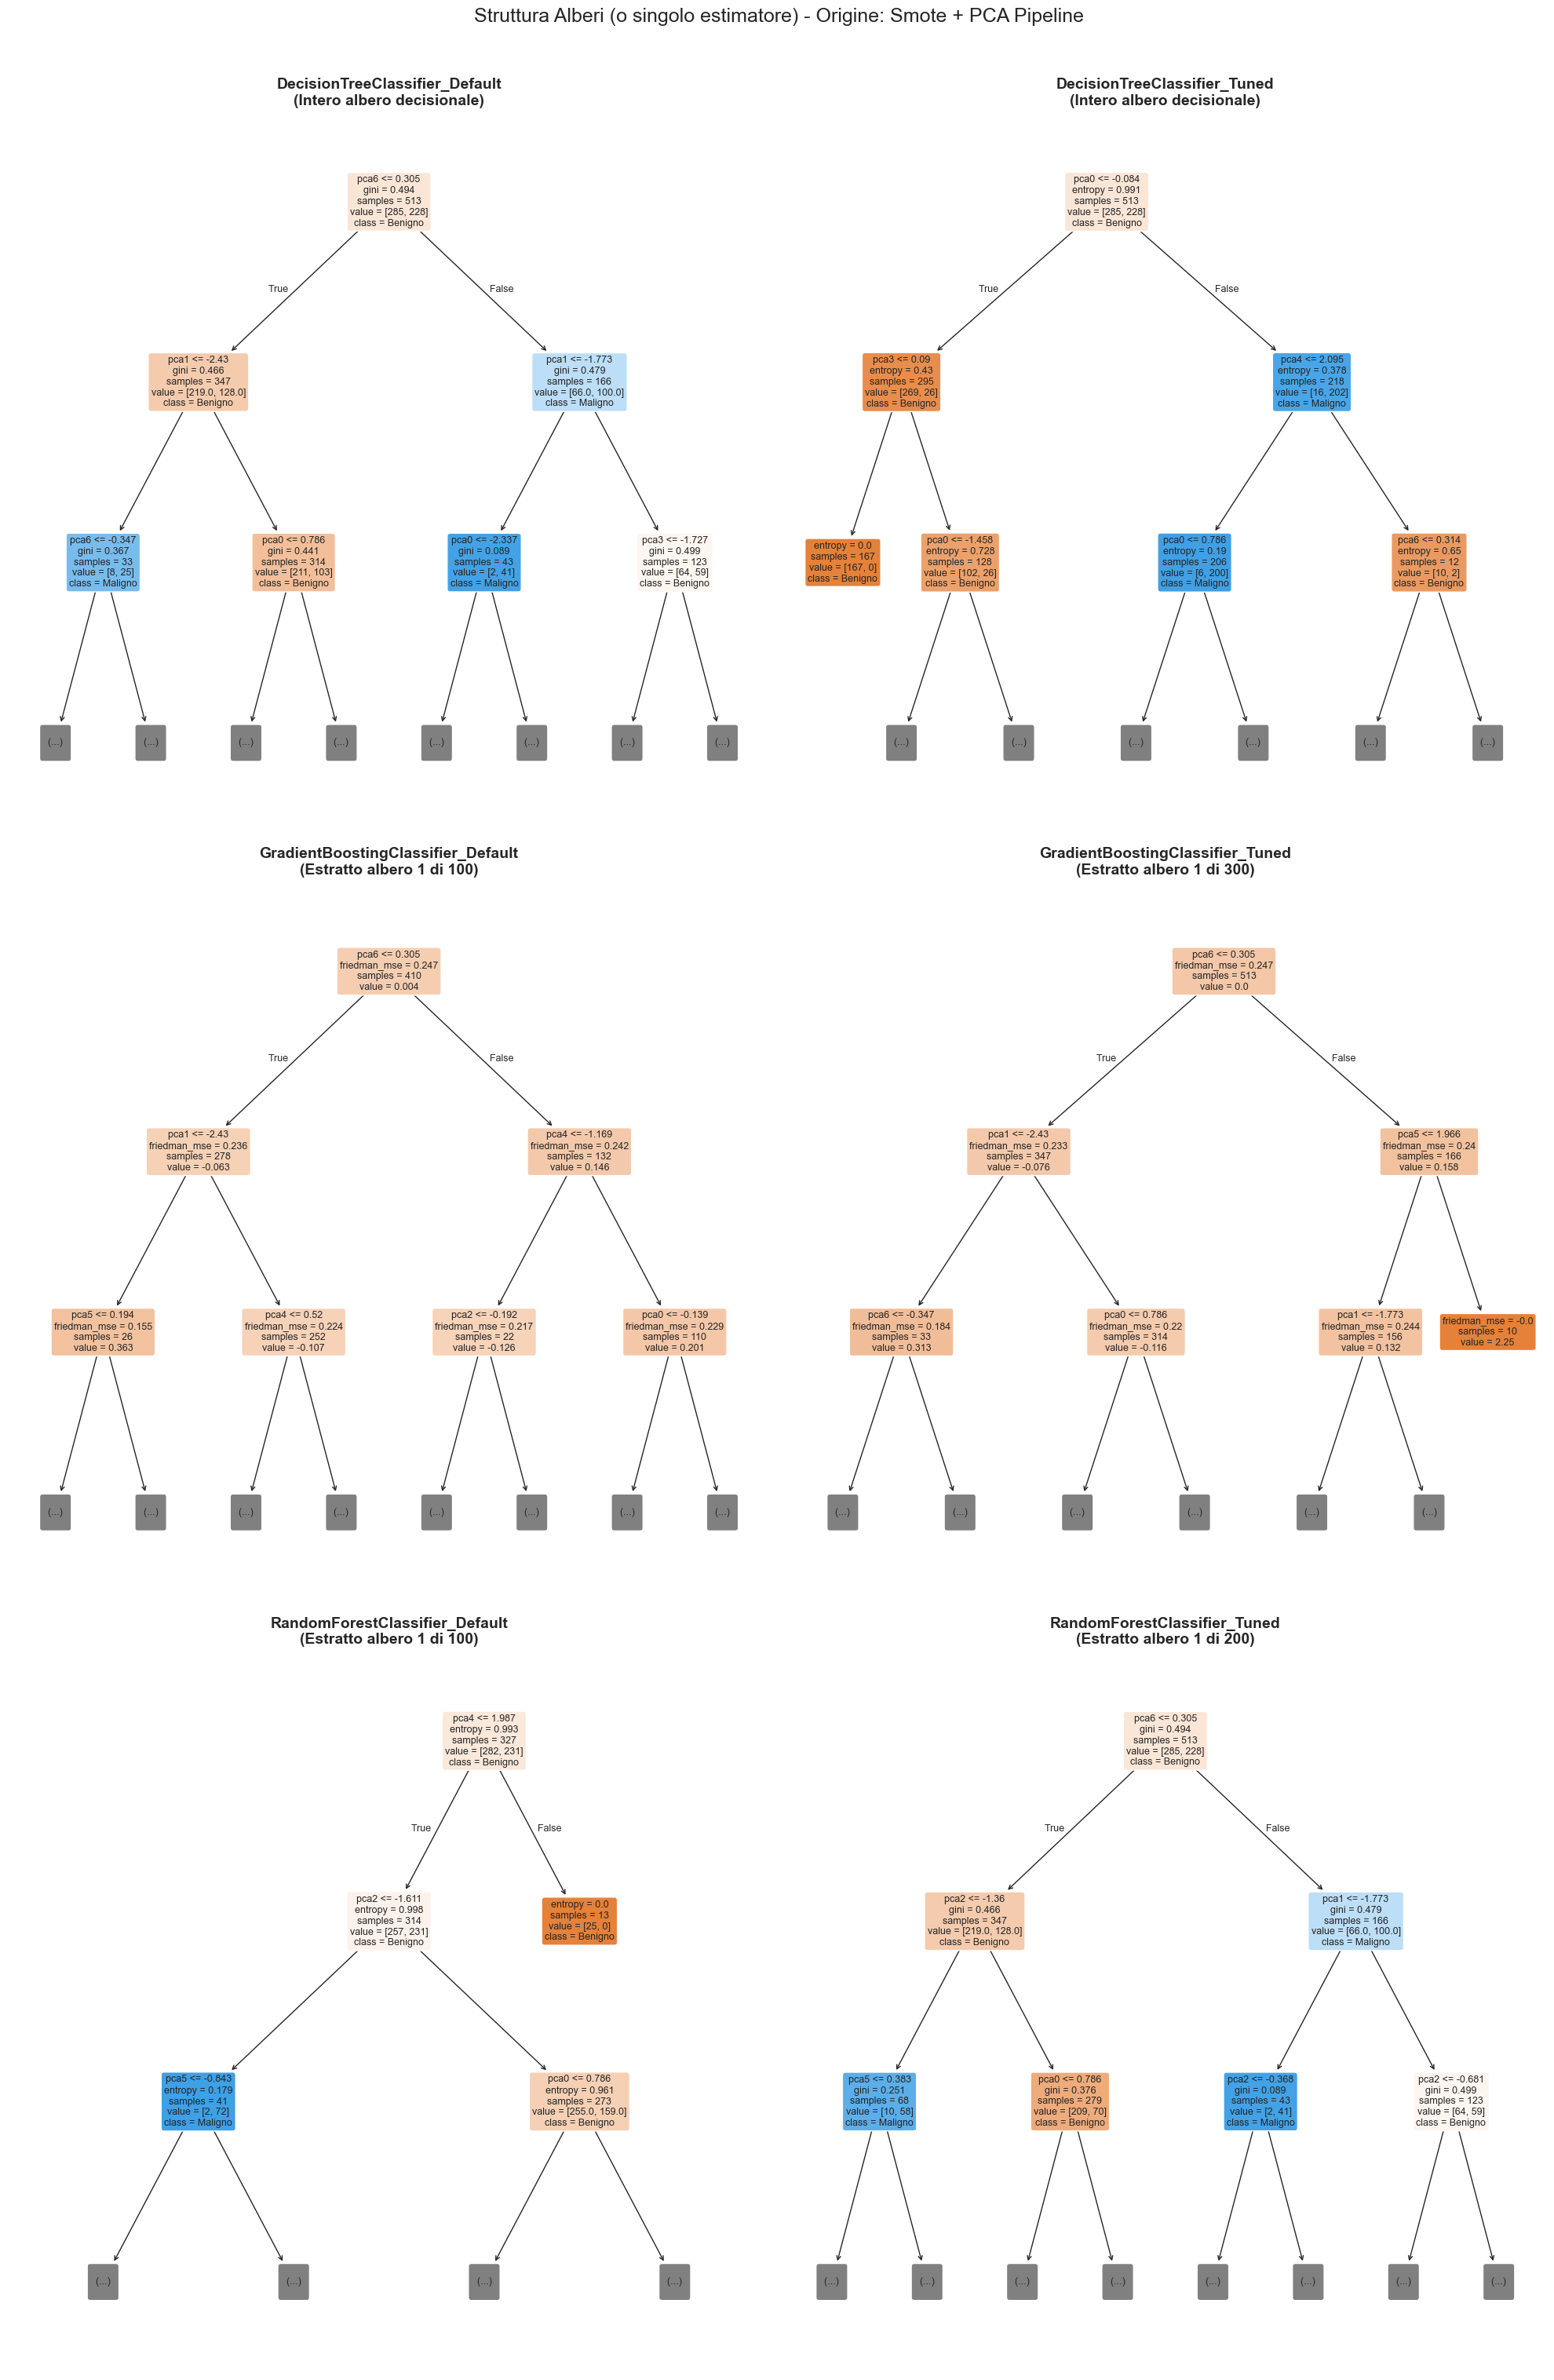

In [49]:
plot_multiple_trees(models_dict=models_smote_pca, pipeline_name='Smote + PCA Pipeline')

## Analisi risultati ottenuti
L'analisi delle performance dei modelli ha evidenziato alcuni fenomeni interessanti legati alla natura intrinseca dei dati di partenza e alle metodologie di validazione adottate.

### Modelli migliori
Focalizzandosi sulla **recall** (scelta come scoring discriminante), è possibile decretare il vincitore di questa sperimentazione.
I report di classificazione e le matrici di confusione evidenziano un trend netto attraverso tutte le pipeline implementate: il modello **SVC** si conferma come il classificatore più solido e performante dell'intero progetto.
L'SVC mantiene prestazioni eccellenti in entrambe le versioni (**Default** e **Tuned**), comparendo sistematicamente nella top 2 dei migliori modelli per recall in tutte le pipeline, dimostrando una versatilità eccezionale sia nello scenario ad alta dimensionalità che nello scenario con minori dimensioni.

### Default vs Tuned
Osservando le metriche grezze, emerge un risultato apparentemente controintuitivo: i modelli **Default** sembrano spesso performare in modo molto simile alle versioni sottoposte a fine-tuning (modelli Tuned).

Questo fenomeno trova giustificazione nella qualità eccezionale del dataset di partenza: i dati sono puliti, non richiedono imputazione di valori mancanti e presentano feature geometriche con un altissimo potere predittivo. In uno scenario così "favorevole", la complessità aggiuntiva di un modello ottimizzato raggiunge rapidamente un plateau di performance.

È fondamentale notare che il confronto diretto tra le due famiglie di modelli è influenzato dalla metodologia di validazione.
I modelli Default sono stati valutati tramite k-fold cross validation (restituendo media e deviazione standard), ottenendo una stima robusta che utilizza tutto il dataset.
I modelli Tuned (ottimizzati tramite GridSearchCV) sono stati validati su un singolo test set e dunque le metriche finali, sebbene alte, soffrono della varianza intrinseca legata allo split iniziale dei dati: una suddivisione "fortunata" o "sfortunata" del test set può influenzare significativamente il punteggio finale, a differenza della stabilità garantita dalla cross validation.

### Impatto PCA
Il risultato più significativo dal punto di vista teorico riguarda l'uso della Principal Component Analysis (PCA). Secondo il principio della "maledizione della dimensionalotà", all'aumentare delle dimensioni (feature), il volume dello spazio aumenta così velocemente che i dati diventano sparsi, richiedendo un numero esponenziale di campioni per ottenere una generalizzazione statistica affidabile.

In questo progetto, la pipeline che integra la riduzione della dimensionalità, pur utilizzando un numero drasticamente inferiore di feature (componenti sufficienti a spiegare il 90% della varianza), hanno ottenuto risultati estremamente vicini e assimilabili a quelli delle pipeline che presentano una dimensionalità maggiore. Con ciò, si conferma che il contenuto informativo dei dati di partenza è molto denso (molte feature originali sono ridondanti o collineari).